## Import packages

### Requirements

The dependencies we use in this virtual environment are specified below:

- `python==3.9`
- `numpy==1.23.2`
- `pandas==1.5.0`
- `matplotlib==3.6.1`
- `geopandas==0.12.1`
- `scikit-learn==1.1.2`
- `scipy==1.8.0`
- `plotly.express==5.10.0`
- `plotly`
- `seaborn`

Several third-party libraries are loaded.

In [37]:
# data processing
import numpy as np
import pandas as pd
import geopandas

# machine-learning
import sklearn.cluster as cluster
from sklearn import metrics
from scipy.spatial.distance import cdist

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
import plotly.io as pio
pio.renderers.default='jupyterlab'

# utility
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# Contribution Statement

**Zhenlin Xu (5721679)**: Split the dataset; Analyze and visualize the main problem of taxi trips’ OD spatial distributions in New York City. 

**Luyang Cao (5685915)**: Analyze the average trip distance per day by hour for weekdays and weekends.

**Yuchen Qi (5695392)**: Visualize sample tip amount distribution with various pickup locations and analyze tip behavior of taxi passengers as well as its possible changes with time and other attributes.

**Xinghao Lou (5698715)**: Analyze the characteristics of  average travel speed in weekdays and weekends by hour.

**Yimin Xu (5696925)**: Analyze the number of trips for different passenger counts per day by hour and the total amount of fares for different passenger counts per day by hour.


# Main research problem: the taxi trips' origins and destinations' spatial distribution in New York City

## Dataset:

The data used in this group project were collected and provided by the NYC Taxi and Limousine Commision (TLC).
Raw data is avaiable at: TLC Trip Record Data - TLC (nyc.gov)
We use the dataset collected from all the yellow taxis in 2014.

## Plot the map of New York City to specify the research region

### Load the shapefile

The map of New York City are needed to plot the spatil distribution of taxi trips' origins and destinations.

A .shapefile (.shp) file of 2010 New York City Boroughs are downloaded from https://geodata.lib.utexas.edu/catalog/nyu-2451-34490. The shapefile contains all the GIS information we need to show the geography of New York City.

Four boroughs' GIS information in New York City  

In [4]:
# load the GIS information from the shapefile.

shapefile_path = "./map/nyu_2451_34490.shp"
nyc_map = geopandas.read_file(shapefile_path)
nyc_map.drop(4, axis=0, inplace=True)
nyc_map.head()

bcode      bname      name         namelsad  \
0  36005      Bronx     Bronx     Bronx County   
1  36047   Brooklyn     Kings     Kings County   
2  36061  Manhattan  New York  New York County   
3  36081     Queens    Queens    Queens County   

                                            geometry  
0  MULTIPOLYGON (((-73.91052 40.91528, -73.91028 ...  
1  MULTIPOLYGON (((-74.01940 40.67957, -74.01935 ...  
2  MULTIPOLYGON (((-73.91520 40.87558, -73.91517 ...  
3  MULTIPOLYGON (((-73.84668 40.59321, -73.84444 ...

### Show the studied area

Text(140.31790940154156, 0.5, 'Latitude')

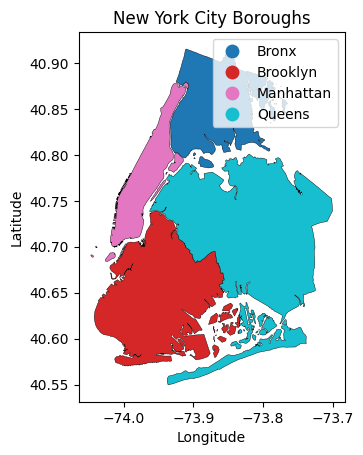

In [5]:
# Draw the static map

f, ax0 = plt.subplots(1, 1)

background = nyc_map.plot(
    'bname',
    ax=ax0,
    figsize=(12,12),
    legend=True,
    **{'edgecolor': 'black', 'linewidth':0.3}
)
ax0.set_title('New York City Boroughs')
ax0.set_xlabel('Longitude')
ax0.set_ylabel('Latitude')

### Draw the interactive map

In [6]:
nyc_map.explore(
    'bname',
    tiles='Stamen Terrain'
)

## Firstly, visualize all the origins and destinations in one day

One day's data can be filtered out. Using that, the origins and destinations' spatial distribution can be visualized.

The code for dataset-splitting process can be found in the `dataset-splitting.ipynbdataset-splitting.ipynb` 

### Load one day's OD dataset

- load into `pd.DataFrame`
- load into `geopandas.GeoDataFrame`


In [7]:
sample_path = "./data/one_day.csv"
columns_used = ['pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
                'dropoff_latitude', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 
                'year', 'month', 'day', 'hour', 'minute', 'second']

sample_df = pd.read_csv(
    sample_path,
    usecols=columns_used
)

# Turn the datatime columns into datatime objects.
sample_df['pickup_datetime']  = pd.to_datetime(sample_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
sample_df['dropoff_datetime'] = pd.to_datetime(sample_df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

# show the shape of DataFrame.
sample_df.shape

(366990, 21)

In [8]:
sample_gdf = geopandas.GeoDataFrame(
    data=sample_df,
    geometry=geopandas.points_from_xy(sample_df.pickup_longitude, sample_df.pickup_latitude),
    # usecols= 
)

sample_gdf['pickup_geometry'] = geopandas.points_from_xy(sample_df.pickup_longitude, sample_df.pickup_latitude)
sample_gdf['dropoff_geometry'] = geopandas.points_from_xy(sample_df.dropoff_longitude, sample_df.dropoff_latitude)

sample_gdf.shape

(366990, 24)

### Draw the spatial distribution of all origins and destinations

Text(0.5, 1.0, 'Destination spatial distribution')

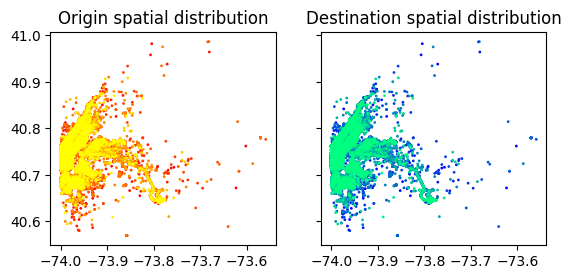

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sample_gdf.plot(
    # column=sample_gdf['pickup_geometry'],
    ax=ax1,
    figsize=(10,10),
    markersize=1,
    cmap='autumn',
)
ax1.set_title("Origin spatial distribution")

sample_gdf.set_geometry("dropoff_geometry")
sample_gdf.plot(
    ax=ax2,
    figsize=(10,10),
    markersize=1,
    cmap='winter',
)
ax2.set_title("Destination spatial distribution")

As shown above, the first impression of the spatial distributions of OD is that **Manhatten** and **Brooklyn** have a large amount of taxi trips

## Next, employee $K$-Means algorithm to find the clustered centers of ODs.

- The cluster centers of ODs are found using k-Means.
- The cluster density can also calculated.
- Two versions of Elbow algorithm are applied to find the proper $k$-value.

### Origin clustering

The `sample_df[pickup_longitude]` and `sample_df[pickup_latitude]` are selected as the input of k-means

In [10]:
# instantiate an instance of K-Means algorithm solver.
kMeans_O = cluster.KMeans(
    n_clusters=50,
    n_init=10,
    init='k-means++',
    max_iter=100,
    verbose=0,
)

# filter to get the input data
O_inputs = sample_df[['pickup_longitude', 'pickup_latitude']]
# O_inputs = sample_df[['pickup_longitude', 'pickup_latitude', 'trip_distance', 'passenger_count',]]


# train and predict the cluster label.
O_labels = kMeans_O.fit_predict(O_inputs)

O_labels.shape

(366990,)

### Destination clustering

The `sample_df[dropoff_longitude]` and `sample_df[dropoff_latitude]` are selected as the input of k-means

In [11]:
# instantiate an instance of K-Means algorithm solver.
kMeans_D = cluster.KMeans(
    n_clusters=50,
    n_init=10,
    init='k-means++',
    max_iter=100,
    verbose=0,
)

# filter to get the input data
D_inputs = sample_df[['dropoff_longitude', 'dropoff_latitude']]
# O_inputs = sample_df[['pickup_longitude', 'pickup_latitude', 'trip_distance', 'passenger_count',]]


# train and predict the cluster label.
D_labels = kMeans_D.fit_predict(D_inputs)

D_labels.shape

(366990,)

### Calculate the number of points in each cluster 

In [12]:
O_labels_df = pd.DataFrame(data=O_labels, columns=['cluster',])
O_labels_df['i'] = 1
# O_labels_df.head()
frequency_O = O_labels_df.groupby('cluster').sum()
frequency_O.head()

i
cluster       
0        17819
1         2663
2         8376
3        10934
4         3847

In [13]:
print(f"max: {int(frequency_O.max())}, min: {int(frequency_O.min())}, average: {int(frequency_O.mean())}")

max: 19277, min: 9, average: 7339


In [14]:
D_labels_df = pd.DataFrame(data=D_labels, columns=['cluster',])
D_labels_df['i'] = 1
# O_labels_df.head()
frequency_D = D_labels_df.groupby('cluster').sum()
frequency_D.head()

i
cluster       
0        10587
1        14050
2         2885
3         1523
4        19300

In [15]:
print(f"max: {int(frequency_D.max())}, min: {int(frequency_D.min())}, average: {int(frequency_D.mean())}")

max: 22778, min: 53, average: 7339


## Elbow algorithm to choose the proper $k$-value 

Two versions of elbow algorithms are used:

- Distortion
- lnertia

In [21]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 100, 3)

X = sample_df[['pickup_longitude', 'pickup_latitude']]

for k in K:
    # Building and fitting the model
    kmeanModel = cluster.KMeans(
        n_clusters=k,
        n_init=10,
        init='k-means++',
        max_iter=100,
        verbose=0,
    ).fit(X)
    
    # train the model
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

### Elbow algorithm using Distortion

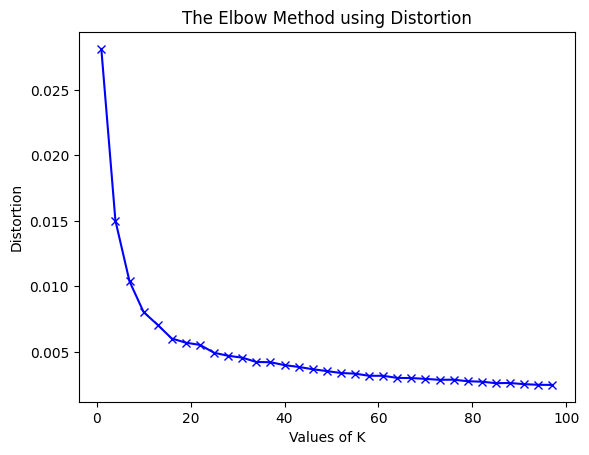

In [22]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

### Elbow algorithm using Inertia

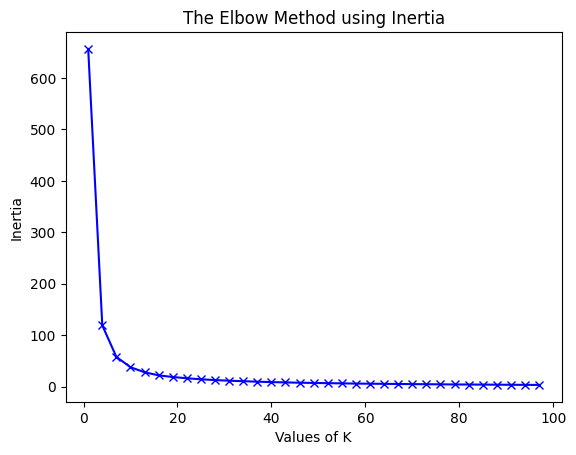

In [23]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Based on the simulation results of two versions of the elbow algorithm, the value of $k$ is chosen as 50 for the following k-means algorithm.

## Visualize OD hotspot clustered centers in one day

### Origin hotspots

In [24]:
cluster_centers_O = geopandas.GeoDataFrame(
    data=kMeans_O.cluster_centers_,
    geometry=geopandas.points_from_xy(kMeans_O.cluster_centers_[:,0], kMeans_O.cluster_centers_[:,1]),
    columns=['lat','lon',] # 'trip_distance','passenger_cnt']
)

Text(41.472222222222214, 0.5, 'Latitude')

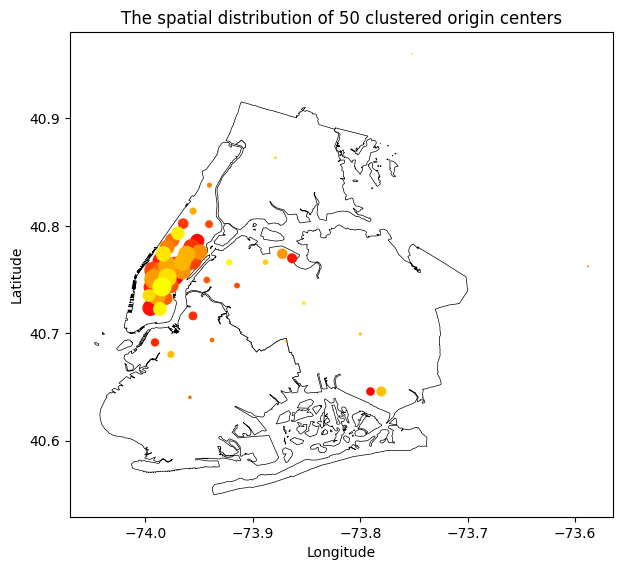

In [26]:
bg = nyc_map.plot(
    'bname',
    # ax=ax0,
    figsize=(7,7),
    legend=True,
    # cmap='PiYG',
    color='white',
    **{
        'facecolor':'grey', 
        'edgecolor':'black',
        'linewidth':  0.5
    }
)

cluster_centers_O.plot(
    ax=bg,
    markersize=frequency_O/100,
    cmap='autumn',
)

bg.set_title('The spatial distribution of 50 clustered origin centers')
bg.set_xlabel('Longitude')
bg.set_ylabel('Latitude')

As the graph shown, the final clustered centers mainly locates at the **Manhatten** considering the pickup positions. 

### Destination hotspots

In [29]:
cluster_centers_D = geopandas.GeoDataFrame(
    data=kMeans_D.cluster_centers_,
    geometry=geopandas.points_from_xy(kMeans_D.cluster_centers_[:,0], kMeans_D.cluster_centers_[:,1]),
    columns=['lat','lon',] # 'trip_distance','passenger_cnt']
)

Text(32.722222222222214, 0.5, 'Latitude')

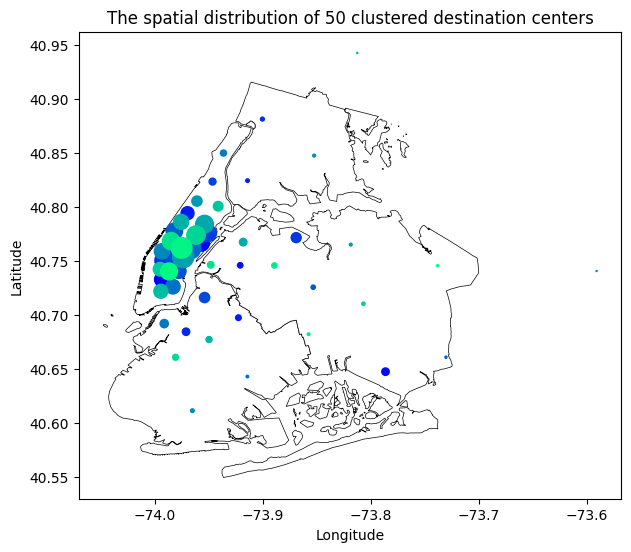

In [30]:
bg = nyc_map.plot(
    'bname',
    # ax=ax0,
    figsize=(7,7),
    legend=True,
    # cmap='PiYG',
    color='white',
    **{
        'facecolor':'grey', 
        'edgecolor':'black',
        'linewidth':  0.5
    }
)

cluster_centers_D.plot(
    ax=bg,
    markersize=frequency_D/100,
    cmap='winter',
)

bg.set_title('The spatial distribution of 50 clustered destination centers')
bg.set_xlabel('Longitude')
bg.set_ylabel('Latitude')

Similarly, the final clustered centers of destinations also mainly locates at the **Manhatten** considering the dropoff positions. 

Text(24.0, 0.5, 'Latitude')

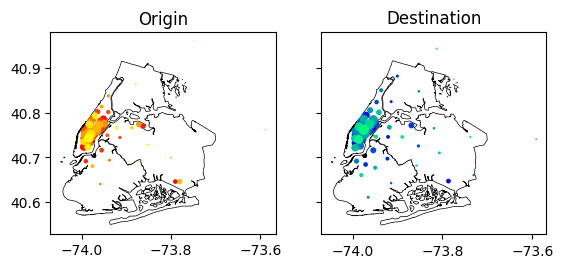

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.set_title('Origin')
bg1 = nyc_map.plot(
    'bname',
    ax=ax1,
    figsize=(8,8),
    legend=True,
    # cmap='PiYG',
    color='white',
    **{
        'facecolor':'dark', 
        'edgecolor':'black',
        'linewidth':  0.5
    }
)

ax2.set_title('Destination')
bg2 = nyc_map.plot(
    'bname',
    ax=ax2,
    figsize=(8,8),
    legend=True,
    # cmap='PiYG',
    color='white',
    **{
        'facecolor':'dark', 
        'edgecolor':'black',
        'linewidth':  0.5
    }
)

cluster_centers_O.plot(
    ax=ax1,
    markersize=frequency_O/500,
    cmap='autumn',
)

bg.set_title('The spatial distribution of 50 clustered origin centers')
bg.set_xlabel('Longitude')
bg.set_ylabel('Latitude')

cluster_centers_D.plot(
    ax=ax2,
    markersize=frequency_D/500,
    cmap='winter',
)

bg.set_title('The spatial distribution of 50 clustered destination centers')
bg.set_xlabel('Longitude')
bg.set_ylabel('Latitude')

## Considering more information from the dataset

In the previous analysis, only the latitude and longitude are considered as the input. 

However, the type of passengers and the trip characteristics can also have some spatial patterns. Thus, we select two other variables as the third input into the k-means algorithm:

- Passenger number
- Trip distance

### Considering the passenger number

In [38]:
# instantiate an instance of K-Means algorithm solver.
kMeans_1 = cluster.KMeans(
    n_clusters=50,
    n_init=10,
    init='k-means++',
    max_iter=100,
    verbose=0,
)

# filter to get the input data
# O_inputs = sample_df[['pickup_longitude', 'pickup_latitude']]
O_inputs = sample_df[['pickup_longitude', 'pickup_latitude', 'passenger_count',]]


# train and predict the cluster label.
O_labels = kMeans_1.fit_predict(O_inputs)

# O_labels.shape
O_labels_df = pd.DataFrame(data=O_labels, columns=['cluster',])
O_labels_df['i'] = 1
# O_labels_df.head()
frequency_O = O_labels_df.groupby('cluster').sum()
# frequency_O.head()

Text(32.722222222222214, 0.5, 'Latitude')

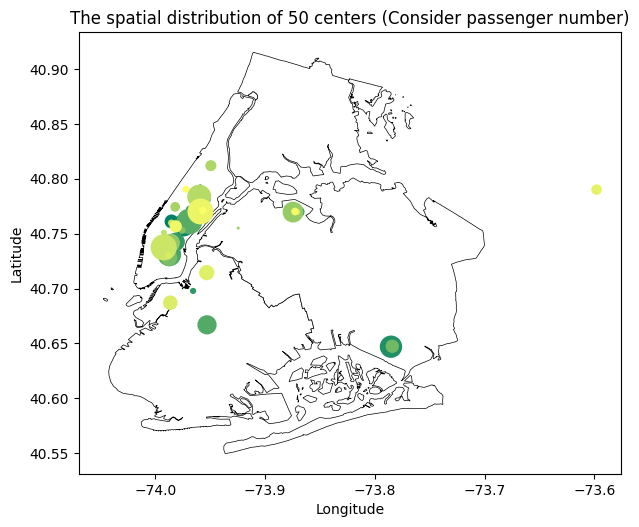

In [43]:
cluster_centers_1 = geopandas.GeoDataFrame(
    data=kMeans_1.cluster_centers_,
    geometry=geopandas.points_from_xy(kMeans_1.cluster_centers_[:,0], kMeans_1.cluster_centers_[:,1]),
    columns=['lat','lon','passenger_cnt']
)

bg = nyc_map.plot(
    'bname',
    # ax=ax0,
    figsize=(7,7),
    legend=True,
    # cmap='PiYG',
    color='white',
    **{
        'facecolor':'grey', 
        'edgecolor':'black',
        'linewidth':  0.5
    }
)

cluster_centers_1.plot(
    ax=bg,
    markersize=frequency_O/100,
    cmap='summer',
)

bg.set_title('The spatial distribution of 50 centers (Consider passenger number)')
bg.set_xlabel('Longitude')
bg.set_ylabel('Latitude')

It seems that the spatial distribution has a subtle shift to the southeasten direction.

### Considering the trip distance

In [44]:
# instantiate an instance of K-Means algorithm solver.
kMeans_2 = cluster.KMeans(
    n_clusters=50,
    n_init=10,
    init='k-means++',
    max_iter=100,
    verbose=0,
)

# filter to get the input data
# O_inputs = sample_df[['pickup_longitude', 'pickup_latitude']]
O_inputs = sample_df[['pickup_longitude', 'pickup_latitude', 'trip_distance',]]


# train and predict the cluster label.
O_labels = kMeans_2.fit_predict(O_inputs)

# O_labels.shape
O_labels_df = pd.DataFrame(data=O_labels, columns=['cluster',])
O_labels_df['i'] = 1
# O_labels_df.head()
frequency_O = O_labels_df.groupby('cluster').sum()
# frequency_O.head()

Text(48.195213434676674, 0.5, 'Latitude')

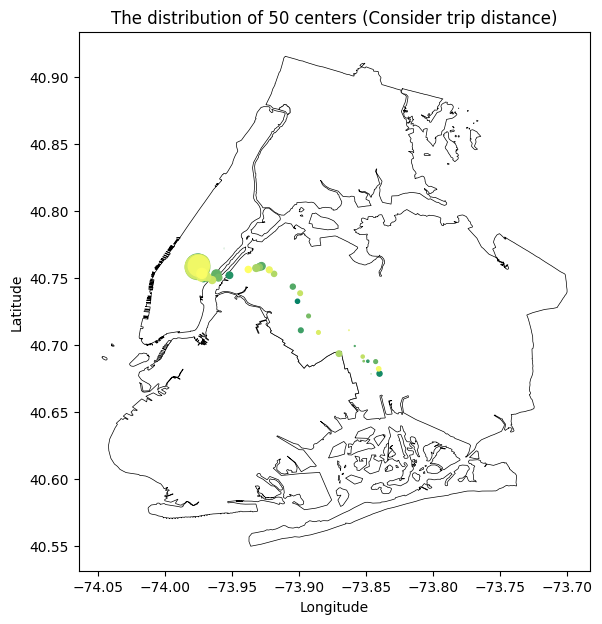

In [45]:
cluster_centers_2 = geopandas.GeoDataFrame(
    data=kMeans_2.cluster_centers_,
    geometry=geopandas.points_from_xy(kMeans_2.cluster_centers_[:,0], kMeans_2.cluster_centers_[:,1]),
    columns=['lat','lon','trip_distance']
)

bg = nyc_map.plot(
    'bname',
    # ax=ax0,
    figsize=(7,7),
    legend=True,
    # cmap='PiYG',
    color='white',
    **{
        'facecolor':'grey', 
        'edgecolor':'black',
        'linewidth':  0.5
    }
)

cluster_centers_2.plot(
    ax=bg,
    markersize=frequency_O/100,
    cmap='summer',
)

bg.set_title('The distribution of 50 centers (Consider trip distance)')
bg.set_xlabel('Longitude')
bg.set_ylabel('Latitude')

It is interesting to discover now that considering the trip distance as another input, the clustered centers distribution is completely different.

## Explore the daily OD distribution evolution.

- k-means to calculate the daily cluster centers of ODs .
- Animated graph of OD distribution in one month

### Load the dataset from January, 2014

In [42]:
# load all the data of January 2014.

jan = pd.read_csv('./data/2014_jan.csv')
jan.shape

(10524005, 22)

### $K$-Means to cluster

In [55]:
# k-Means to process the clustered centers
# Only need to run once
# The results are saved in files like "./data/origin.npy"

o_stack = []
d_stack = []
o_stack2 = []
d_stack2 = []

# process for each day in January, 2014.
for day in range(1,32):
    # print(day)
    df = jan[jan['day'] == day]
    o = df[['pickup_longitude', 'pickup_latitude']]
    d = df[['dropoff_longitude', 'dropoff_latitude']]
    o2 = df[['pickup_longitude', 'pickup_latitude','trip_distance']]
    d2 = df[['dropoff_longitude', 'dropoff_latitude','trip_distance']]
    
    # create 4 k-means object to cluster for 4 cases.
    ko = cluster.KMeans(
        n_clusters=50,
        n_init=10,
        init='k-means++',
        max_iter=100,
        verbose=0,
    )
    kd = cluster.KMeans(
        n_clusters=50,
        n_init=10,
        init='k-means++',
        max_iter=100,
        verbose=0,
    )
    
    ko2 = cluster.KMeans(
        n_clusters=50,
        n_init=10,
        init='k-means++',
        max_iter=100,
        verbose=0,
    )
    kd2 = cluster.KMeans(
        n_clusters=50,
        n_init=10,
        init='k-means++',
        max_iter=100,
        verbose=0,
    )
    
    
    o_label = ko.fit_predict(o)
    d_label = kd.fit_predict(d)
    
    O_labels_df = pd.DataFrame(data=o_label, columns=['cluster',])
    O_labels_df['i'] = 1
    D_lables_df = pd.DataFrame(data=d_label, columns=['cluster',])
    D_lables_df['i'] = 1
    frequency_O = O_labels_df.groupby('cluster').sum()
    frequency_D = D_lables_df.groupby('cluster').sum()
    
    cat_o = np.concatenate([ko.cluster_centers_, frequency_O], 1)
    cat_d = np.concatenate([kd.cluster_centers_, frequency_D], 1)
    
    o_stack.append(cat_o)
    d_stack.append(cat_d)
    
    o_label2 = ko2.fit_predict(o2)
    d_label2 = kd2.fit_predict(d2)
    
    O_labels_df2 = pd.DataFrame(data=o_label2, columns=['cluster',])
    O_labels_df2['i'] = 1
    D_lables_df2 = pd.DataFrame(data=d_label2, columns=['cluster',])
    D_lables_df2['i'] = 1
    frequency_O2 = O_labels_df2.groupby('cluster').sum()
    frequency_D2 = D_lables_df2.groupby('cluster').sum()
    
    cat_o2 = np.concatenate([ko2.cluster_centers_, frequency_O2], 1)
    cat_d2 = np.concatenate([kd2.cluster_centers_, frequency_D2], 1)
    
    o_stack2.append(cat_o2)
    d_stack2.append(cat_d2)
    
# concatenate the array    
o = np.concatenate(o_stack)
d = np.concatenate(d_stack)
o2 = np.concatenate(o_stack2)
d2 = np.concatenate(d_stack2)

# save into local npy zip files.
np.save('./data/origin.npy', o)
np.save('./data/destin.npy', d)
np.save('./data/origin2.npy', o2)
np.save('./data/destin2.npy', d2)

In [50]:
origin = np.load('./data/origin.npy')
destin = np.load('./data/destin.npy')
origin2 = np.load('./data/origin2.npy')
destin2 = np.load('./data/destin2.npy')

days = []
for day in range(1,32):
    this_day = [day for _ in range(50)]
    days = days + this_day

origin = pd.DataFrame(data=origin, columns=['lon', 'lat','number'])
destin = pd.DataFrame(data=destin, columns=['lon', 'lat','number'])
origin['day'] = days
destin['day'] = days

origin2 = pd.DataFrame(data=origin2, columns=['lon', 'lat','dis', 'number'])
destin2 = pd.DataFrame(data=destin2, columns=['lon', 'lat','dis', 'number'])
origin2['day'] = days
destin2['day'] = days

### Visualize the animation distribution of OD

In [63]:
# control the output of plotly

html_render = False
if html_render:
    pio.renderers.default='notebook'   # html can work well with plotly
else:
    pio.renderers.default='jupyterlab' # jupyter notebook/lab can work well with plotly

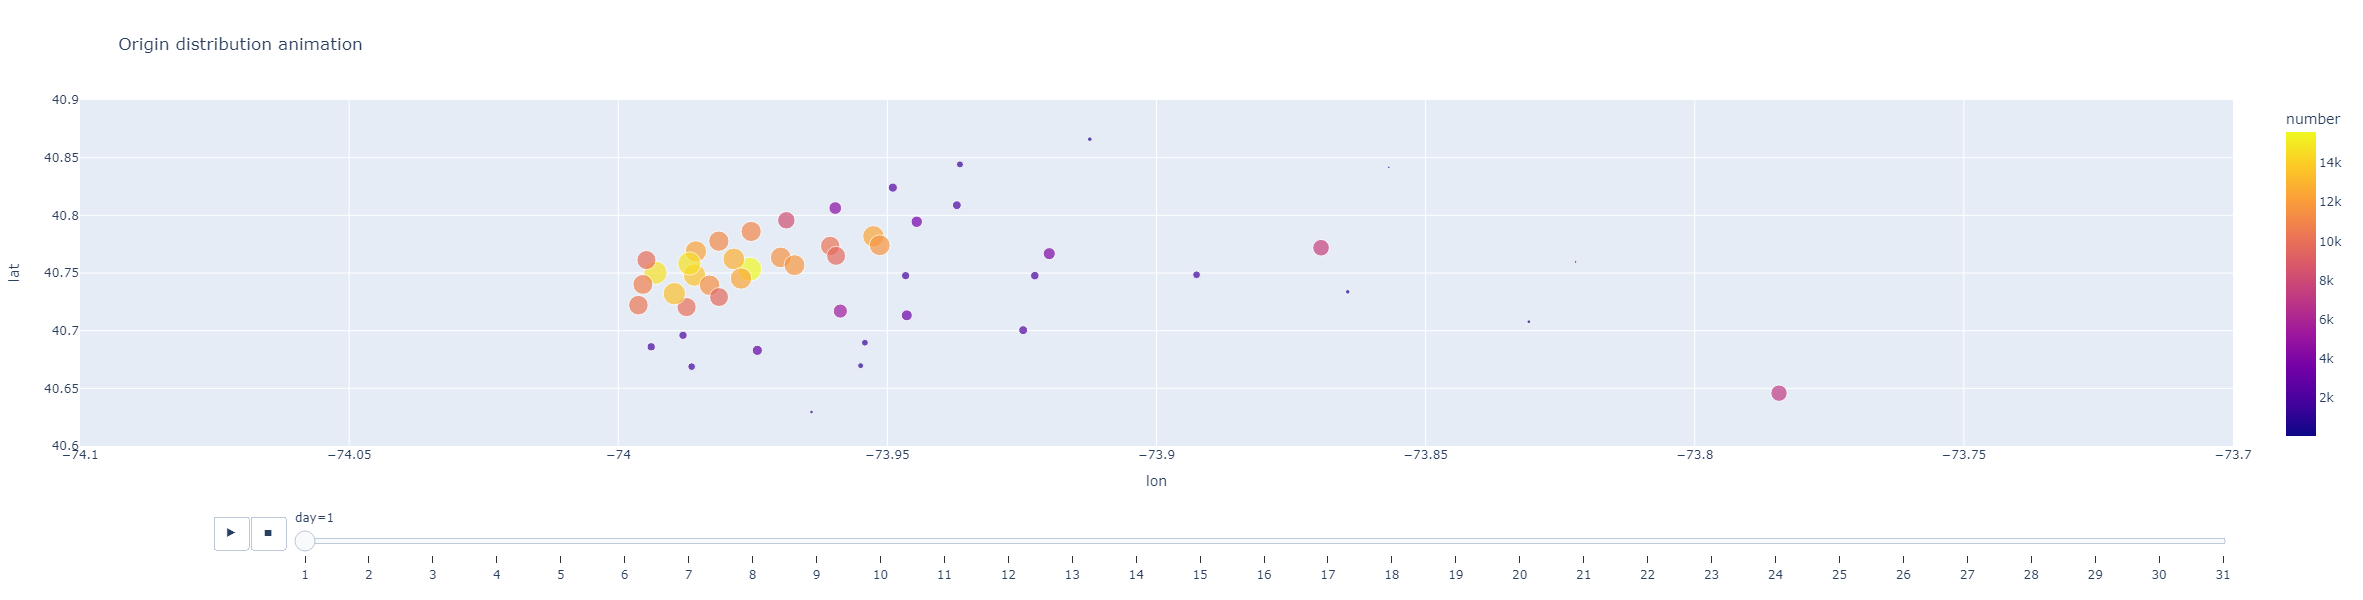

In [64]:
px.scatter(
    origin,
    x='lon', y='lat',
    animation_frame='day',
    size='number', color='number',
    width=600, height=600, 
    title='Origin distribution animation',
    range_x=[-74.1,-73.7],
    range_y=[40.6, 40.9]
)

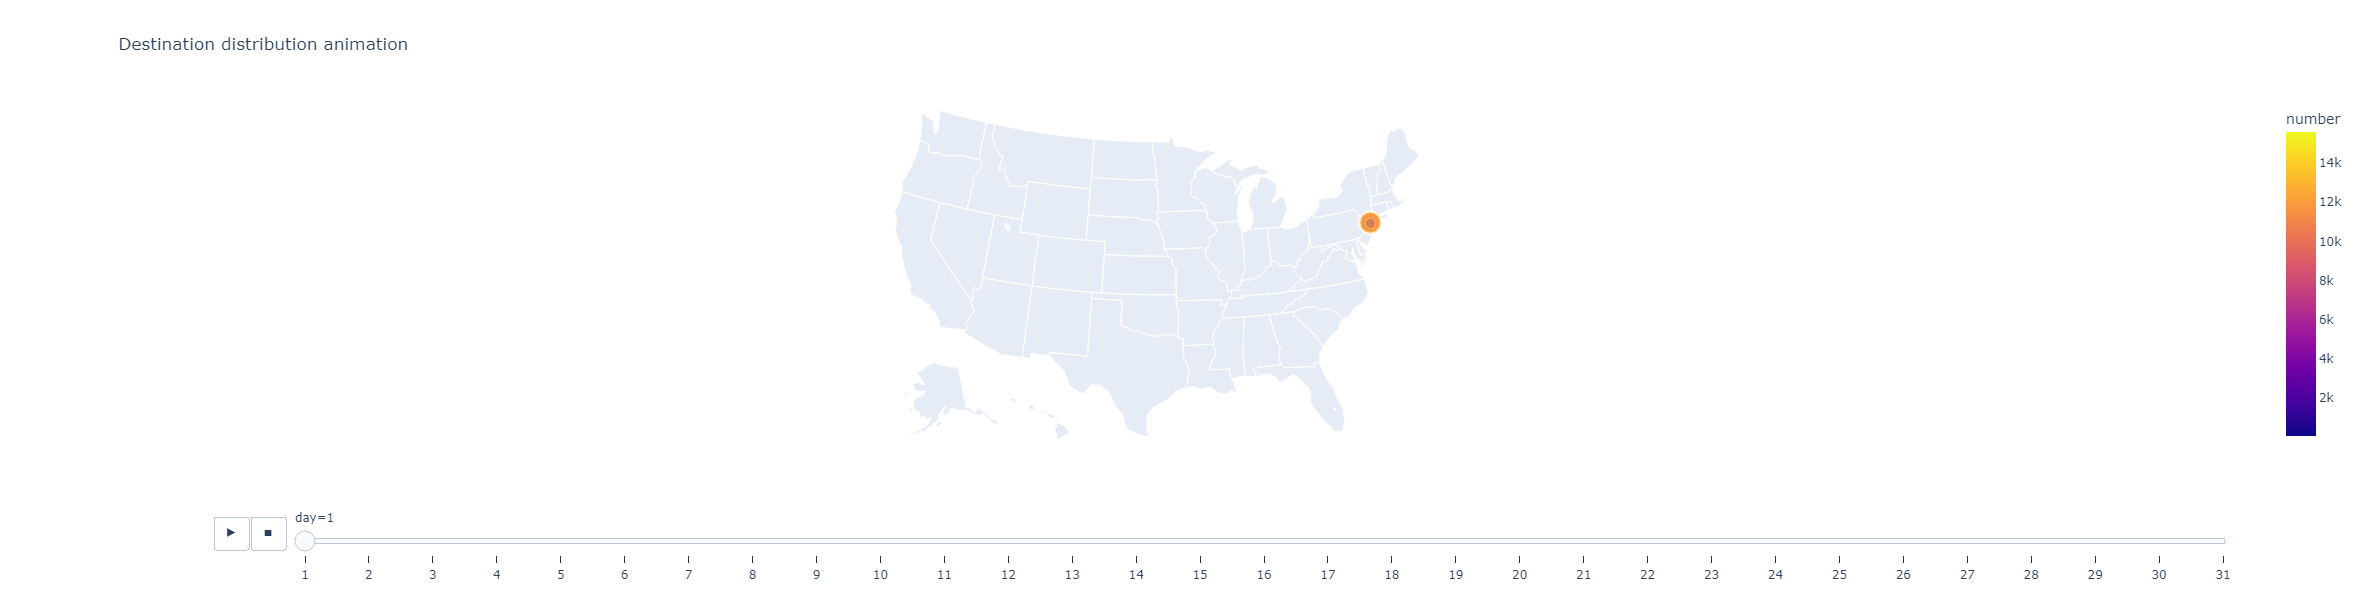

In [65]:
px.scatter_geo(
    origin,
    lon='lon', lat='lat',
    animation_frame='day',
    size='number', color='number',
    width=600, height=600, 
    title='Destination distribution animation',
    # range_x=[-74.1,-73.7],
    # range_y=[40.6, 40.9]
    scope='usa',    
)

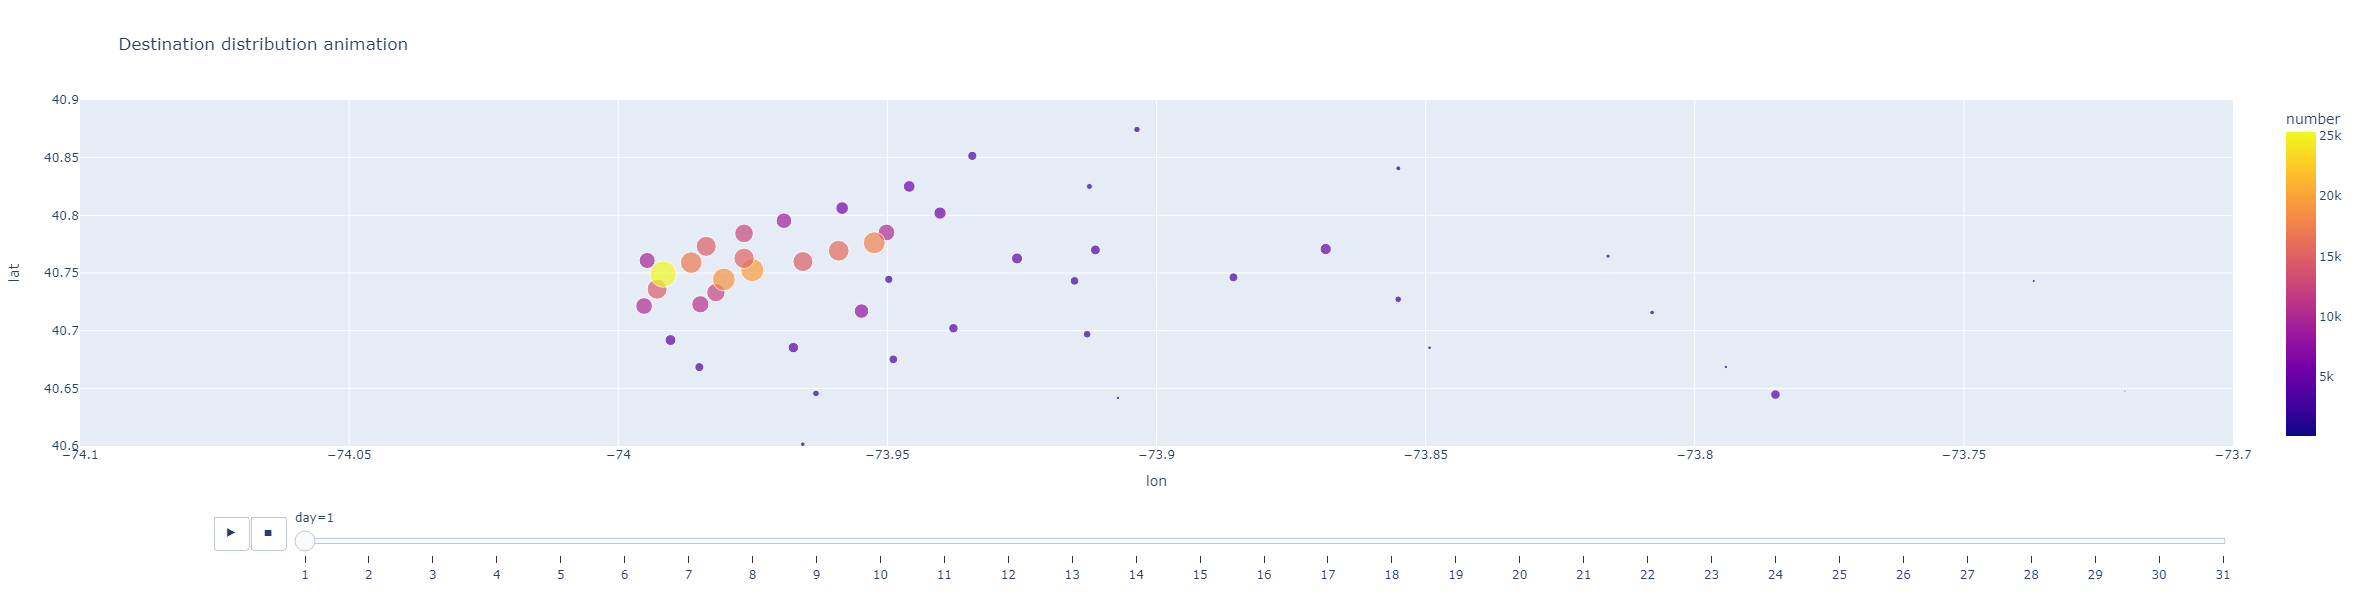

In [66]:
px.scatter(
    destin,
    x='lon', y='lat',
    animation_frame='day',
    size='number', color='number',
    width=600, height=600, 
    title='Destination distribution animation',
    range_x=[-74.1,-73.7],
    range_y=[40.6, 40.9]
)

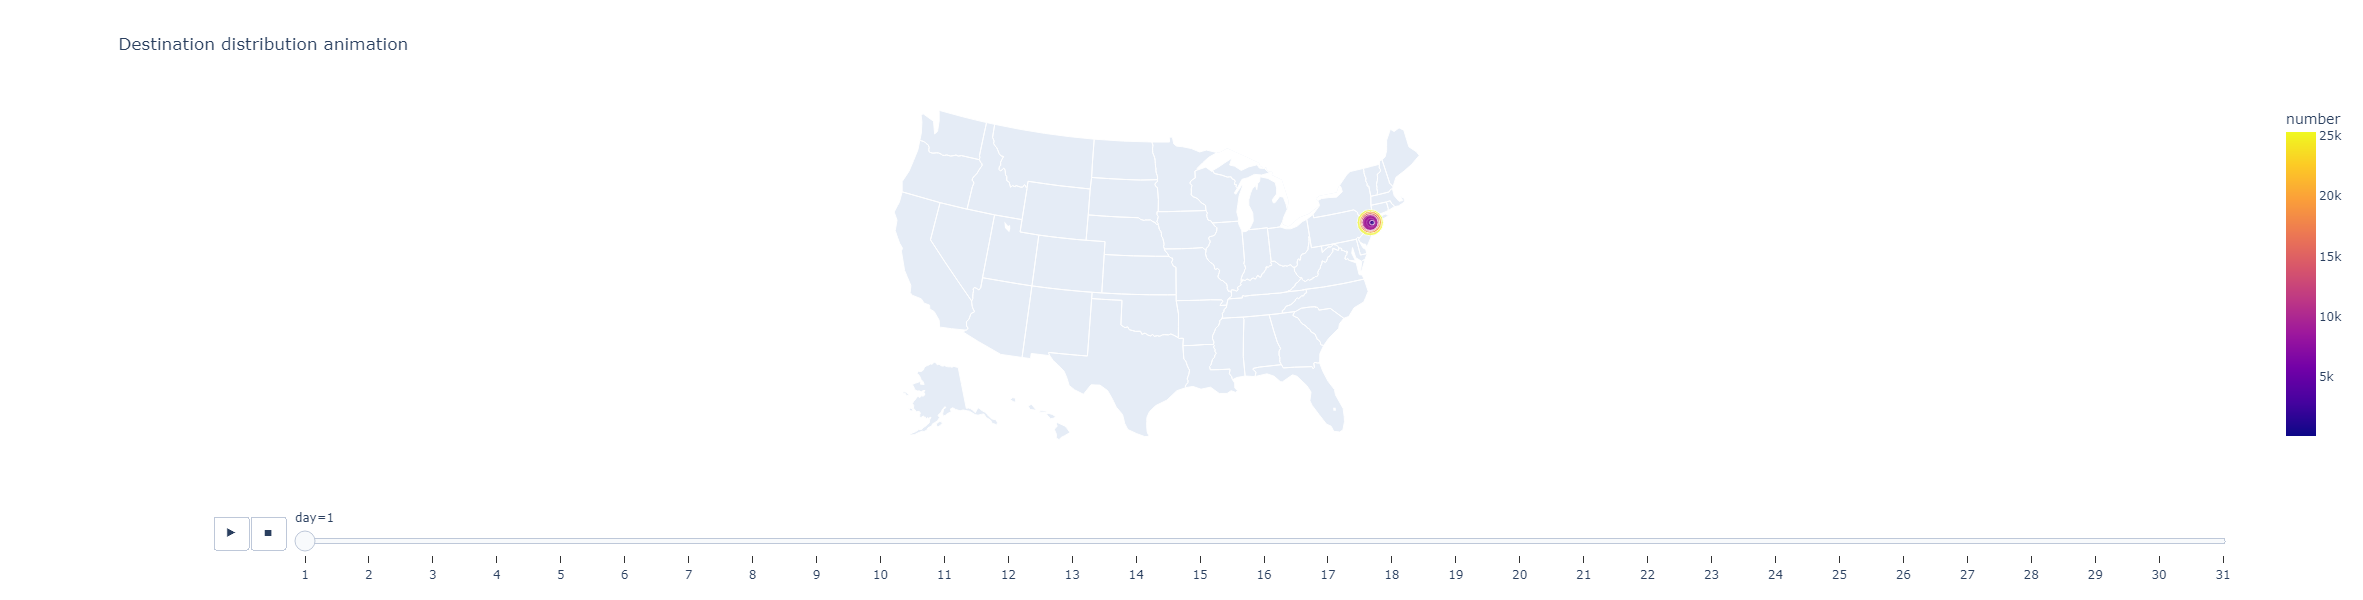

In [67]:
px.scatter_geo(
    destin,
    lon='lon', lat='lat',
    animation_frame='day',
    size='number', color='number',
    width=600, height=600, 
    title='Destination distribution animation',
    # range_x=[-74.1,-73.7],
    # range_y=[40.6, 40.9]
    scope='usa',    
)

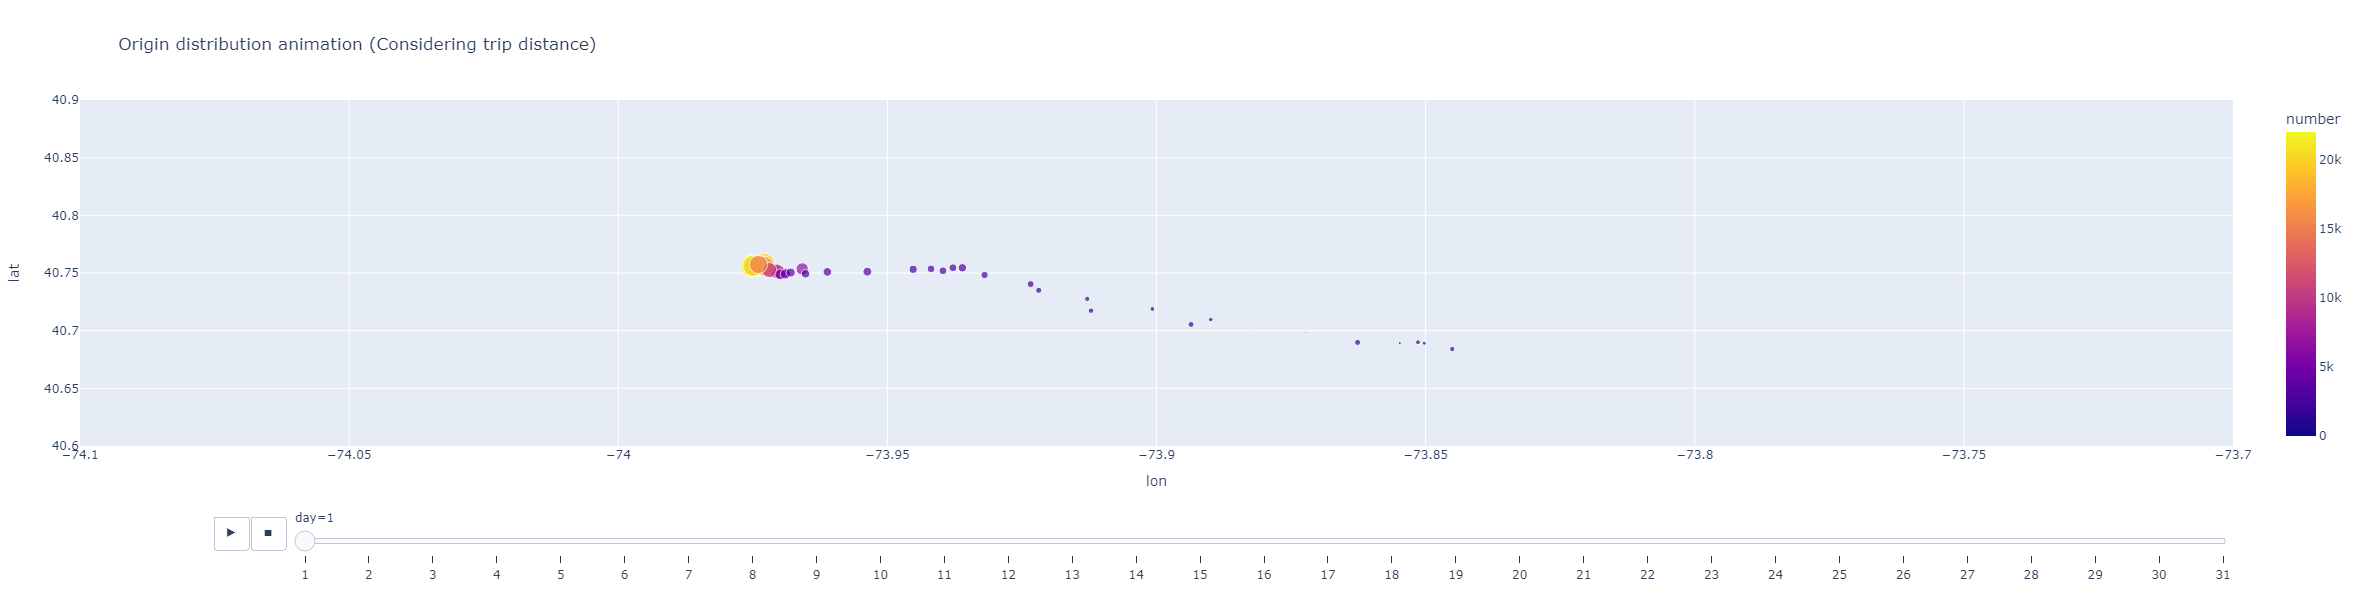

In [68]:
px.scatter(
    origin2,
    x='lon', y='lat',
    animation_frame='day',
    size='number', color='number',
    width=600, height=600, 
    title='Origin distribution animation (Considering trip distance)',
    range_x=[-74.1,-73.7],
    range_y=[40.6, 40.9]
)

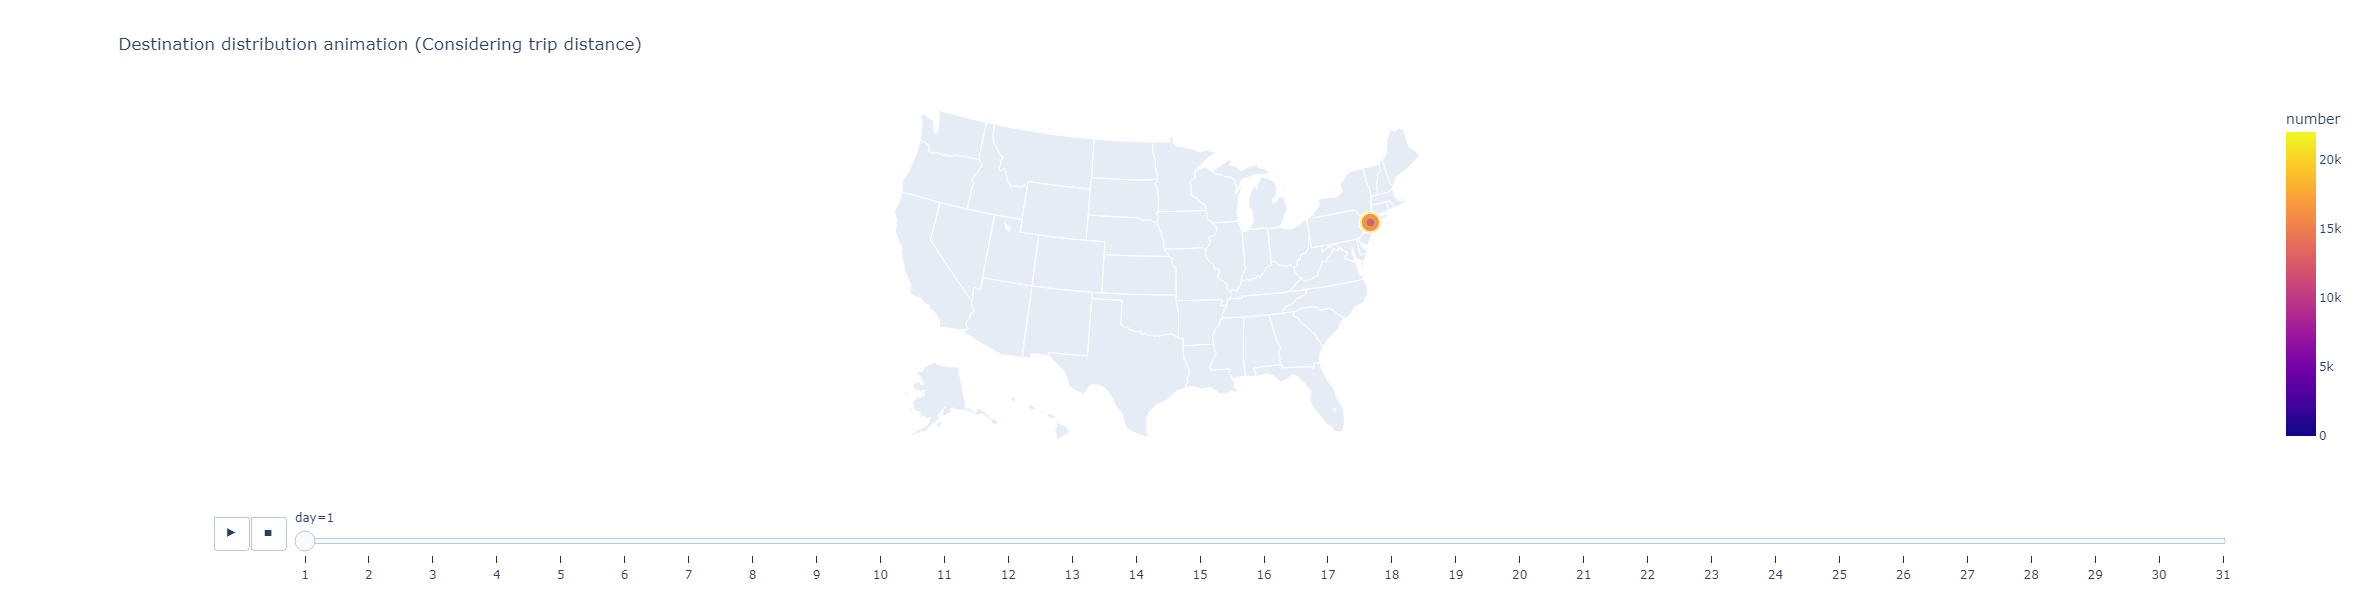

In [69]:
px.scatter_geo(
    origin2,
    lon='lon', lat='lat',
    animation_frame='day',
    size='number', color='number',
    width=600, height=600, 
    title='Destination distribution animation (Considering trip distance)',
    # range_x=[-74.1,-73.7],
    # range_y=[40.6, 40.9]
    scope='usa',    
)

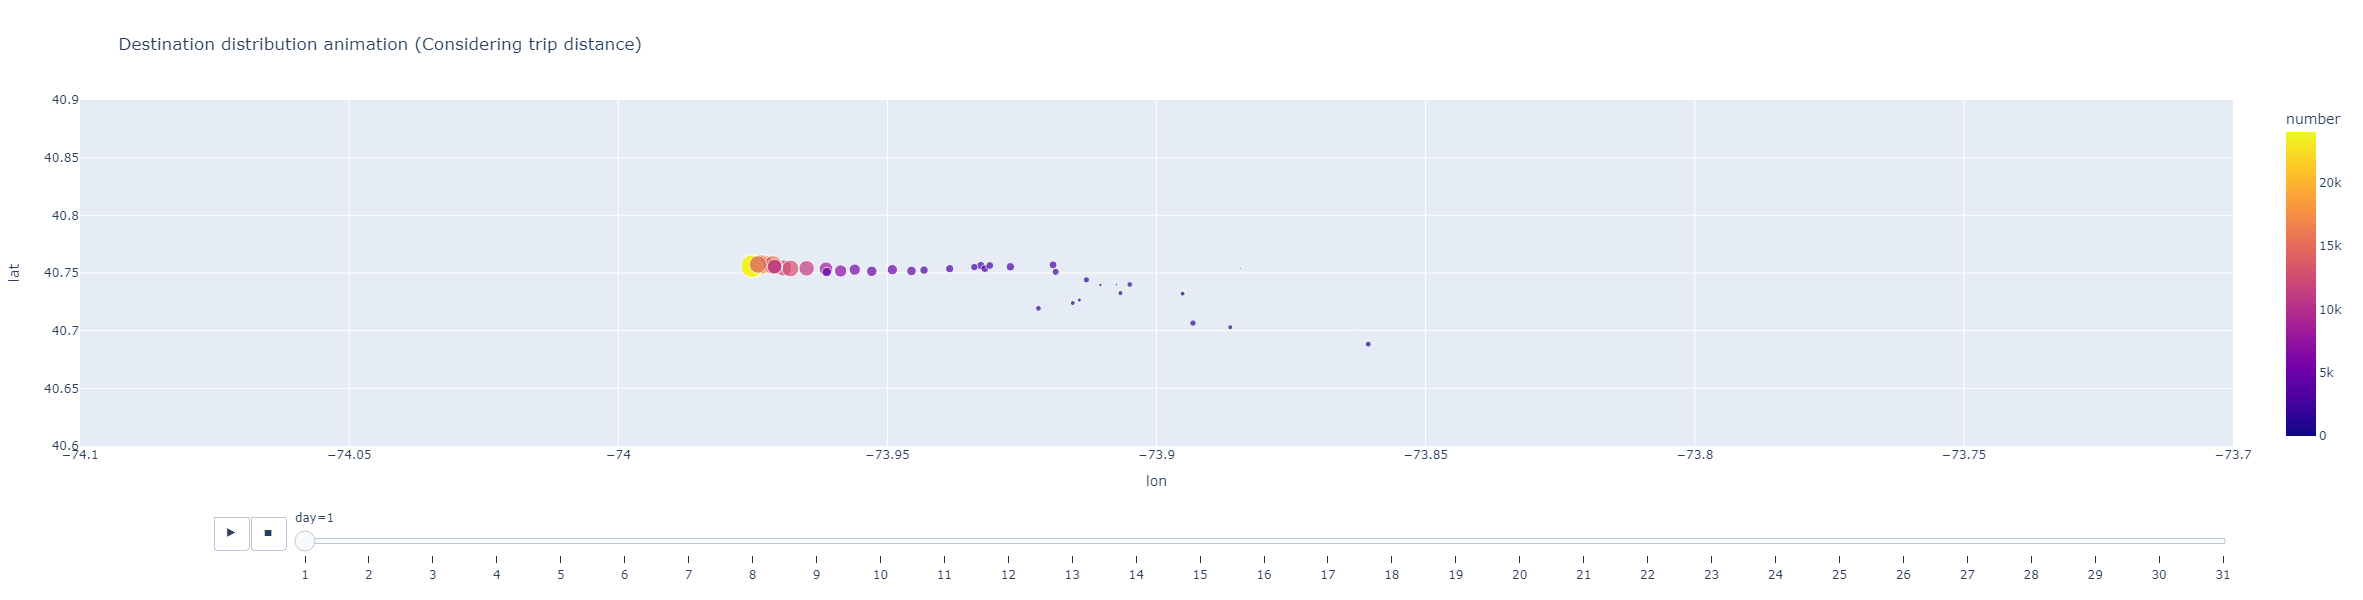

In [70]:
px.scatter(
    destin2,
    x='lon', y='lat',
    animation_frame='day',
    size='number', color='number',
    width=600, height=600, 
    title='Destination distribution animation (Considering trip distance)',
    range_x=[-74.1,-73.7],
    range_y=[40.6, 40.9]
)

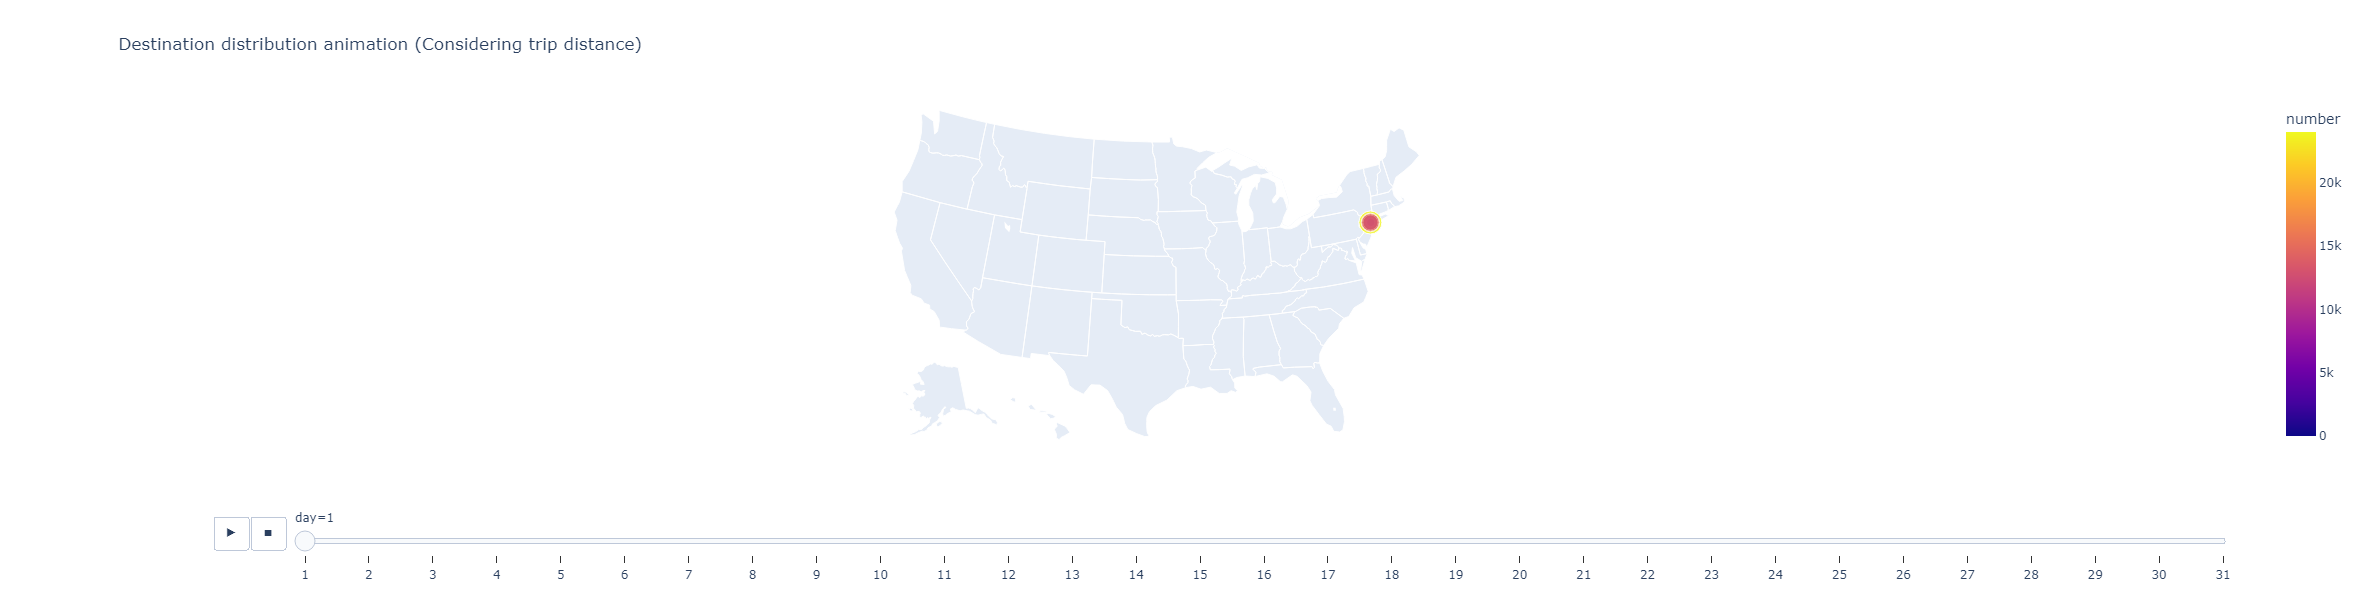

In [71]:
px.scatter_geo(
    destin2,
    lon='lon', lat='lat',
    animation_frame='day',
    size='number', color='number',
    width=600, height=600, 
    title='Destination distribution animation (Considering trip distance)',
    # range_x=[-74.1,-73.7],
    # range_y=[40.6, 40.9]
    scope='usa',    
)

## Conclusion

In the main problem, we study the **spatial distribution of taxi trips' origins and destinations**. 

Firstly, an illustration of all the origins and destinations is shown to find the which district in New York City has the largest amount of trip generations and attractions. **Manhatten** has a larger amount of demands that other 3 districts. 

Then we analyse the cluster centers of taxi trips in New York City in a particular day. K-means algorithm is employed to cluster and a proper $k$ value is selected using two versions of elbow algorithm. Different features combinations are chosen as input to the K-means algorithm for origins and destination, respectively. 

If only considering the space distance between the origins and destinations, the hotspots of ODs are mainly located at **Manhatten** as we expected. However, considering that the trip choice behaviours can be distinct with different passenger numbers and trip distance. Two other features for the K-Means algorithms are tested by adding passenger numbers or trip distance as the third feature. The results show that with the trip distance, the re-clustered hotspots is totally different.

Finally, we also inspect the daily pattern of OD hotspots evolution. The results show that there are only subtle changes between the hotspots. In this way, we can conclude that there is a certain pattern and spatial distribution for the NYC taxi trips, with the illustrations in the last section. 

# Sub-problem 1: The relationship between number of taxi trips and the total amount of fares 

## Data processing for number of trips and total amount of fares for passenger count per hour(yellow taxi)

In [72]:
td=pd.read_csv('./data/2014_jan.csv')
td=td[td['passenger_count']!=0]
tf=td.groupby(['day','hour','passenger_count']).count()
tf.reset_index(inplace=True)

tf2=td.groupby(['day','hour','passenger_count']).sum()
tf2.reset_index(inplace=True)

## Animation of the change of number of trips for passenger count per hour every day in a month(yellow taxi)

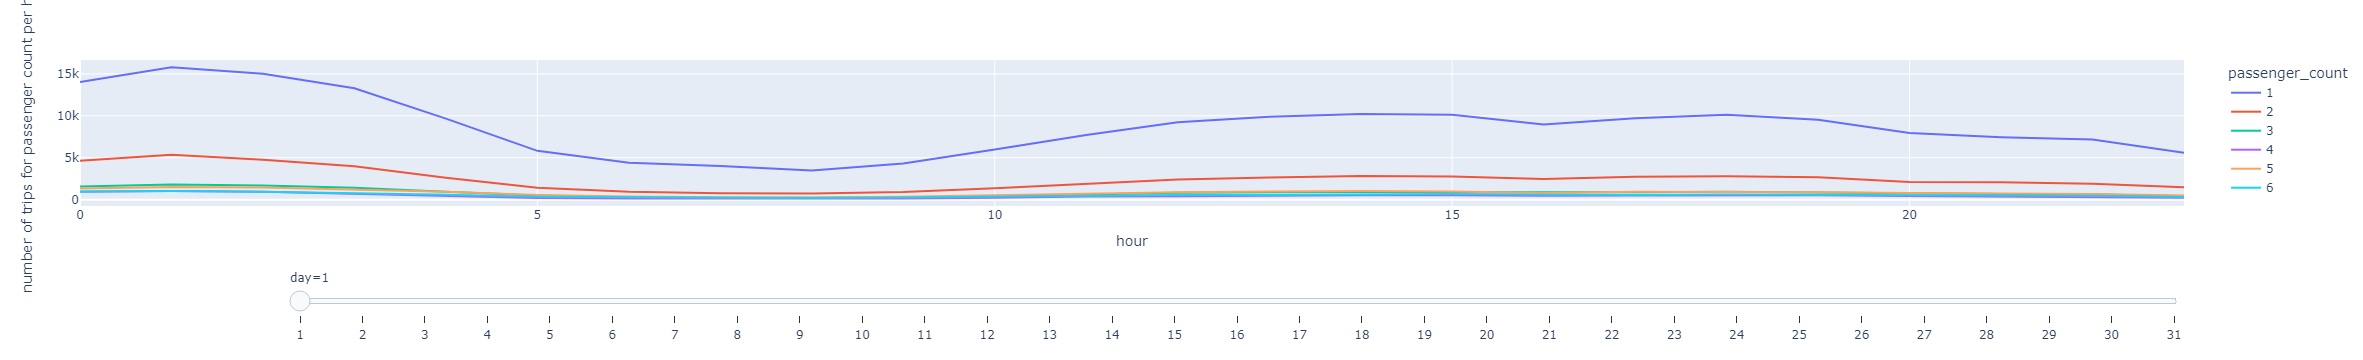

In [73]:
fig = px.line(tf, x=tf['hour'], y=tf['pickup_datetime'], color=tf['passenger_count'], animation_frame=tf['day'])
fig["layout"].pop("updatemenus")
fig.update_yaxes(title="number of trips for passenger count per hour")
fig.show()

From the figure, it can be seen that the number of trips for 1 passenger count is the highest among that of different passenger counts and the number of trips mainly start to increase from 5am in a month.

## Animation of the change of total amount of fares for passenger count per hour every day in a month(yellow taxi)

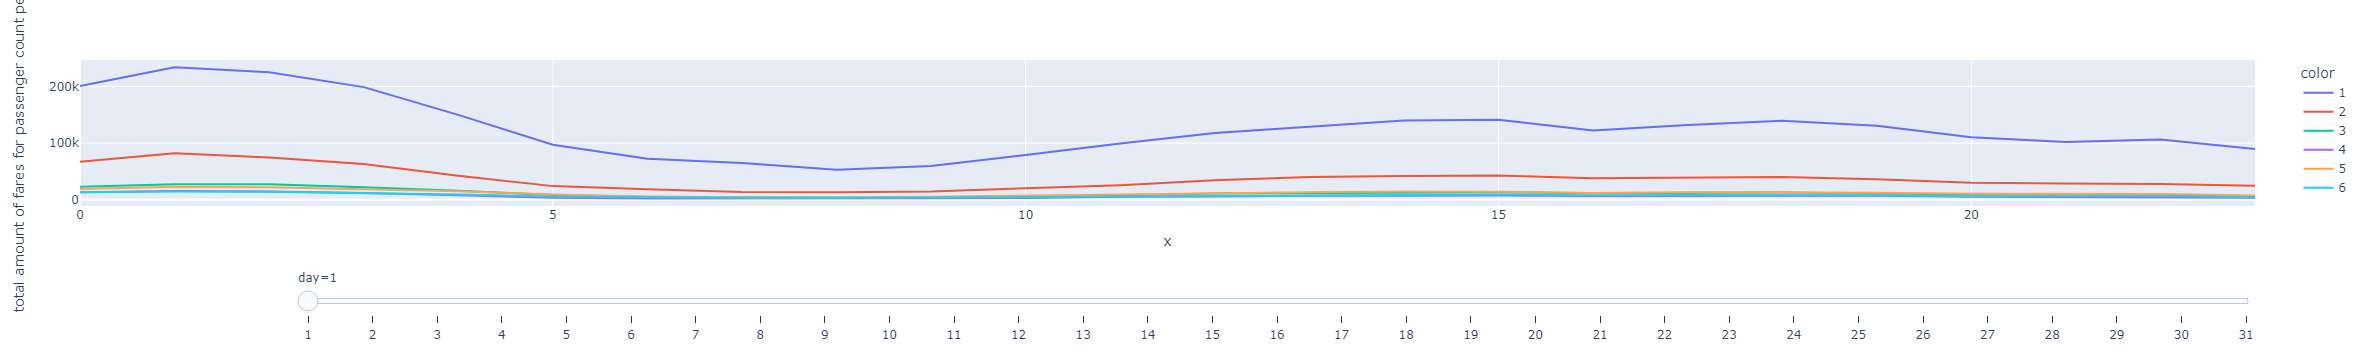

In [74]:
fig = px.line(tf2, x=tf['hour'], y=tf2['total_amount'], color=tf['passenger_count'], animation_frame=tf2['day'])
fig["layout"].pop("updatemenus")
fig.update_yaxes(title="total amount of fares for passenger count per hour")
fig.show()

From the figure, it can be seen that the total amount of fares for 1 passenger count is the highest among that of different passenger counts, and it presents the same trend as the number of trips for different passenger counts.

# Sub-problem 2: Characteristics of the a verage trip distance per hour in weekdays and weekends

The coding process inclues:
- Import Python libraries
- Import the New York City data set
- Group the data set by different days and hours
- Reset the index of the data set
- Replace the trip_distance column by average trip distance
- Plot the average trip distance by hour for the four weeks in January by matplotlib
- Plot the dynamic graph for the average trip distance by hour in the whole month by plotly express

In [61]:
df = pd.read_csv('./data/2014_jan.csv')
gb_hourday = df.groupby(['day','hour'])
gb_hourday.sum()
df1 = gb_hourday.sum()
df1.reset_index(inplace=True)

In [62]:
for a in range(0,31):
    for i in range(0+a*24,24+a*24):
        df1.loc[i,'trip_distance'] = df1.loc[i,'trip_distance']/gb_hourday.get_group((df1.loc[i,'day'],df1.loc[i,'hour']))['trip_distance'].size

In [63]:
for i in range(0,32):
    exec("average_%s=[]"%i)
for j in range(1,32):
    for i in range(0,24):
        exec("df_%s=gb_hourday.get_group((j,i))" %j)
        exec("average_%s.append(df_%s['trip_distance'].sum()/df_%s['trip_distance'].size)" % (j,j,j))

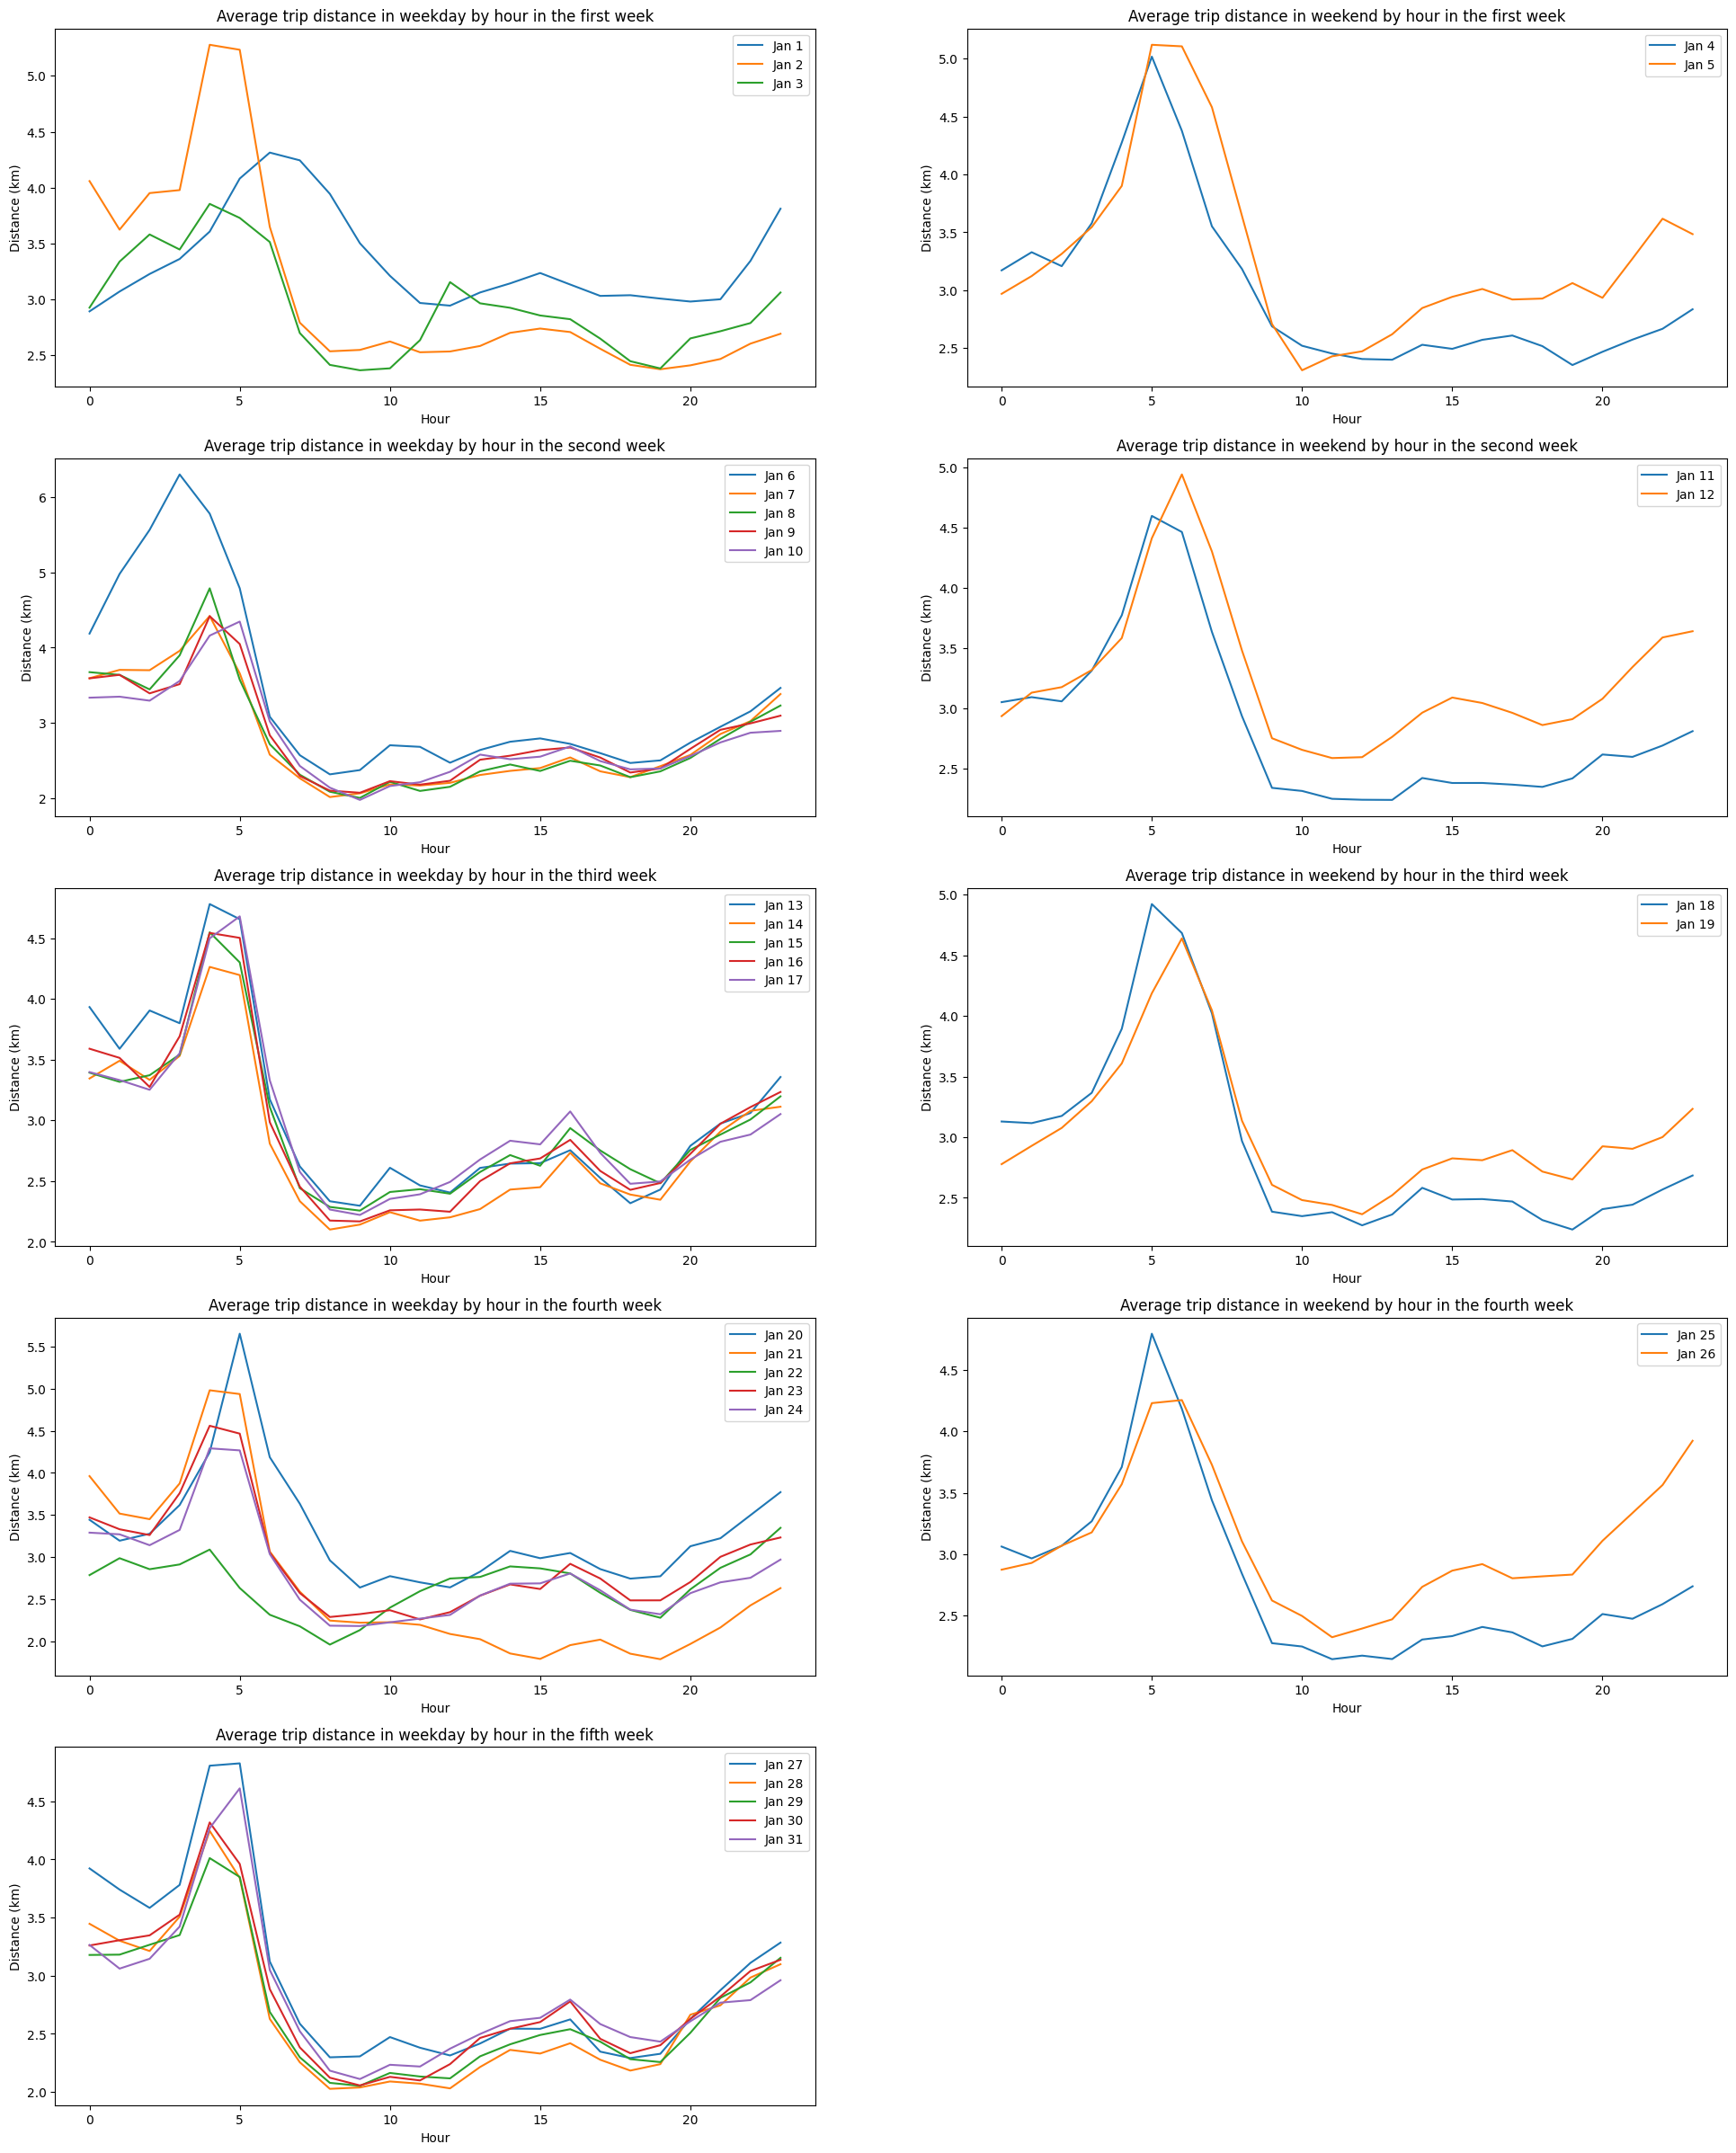

In [64]:
fig = plt.figure(figsize=(24, 30))
gs = fig.add_gridspec(nrows=5, ncols=2)
#
ax = fig.add_subplot(gs[0,0])
x = range(0,24)
ax.plot(x,average_1,label='Jan 1')
ax.plot(x,average_2,label='Jan 2')
ax.plot(x,average_3,label='Jan 3')
ax.set_title('Average trip distance in weekday by hour in the first week')
ax.set_xlabel('Hour')
ax.set_ylabel('Distance (km)')
plt.legend()
#
ax = fig.add_subplot(gs[0,1])
x = range(0,24)
ax.plot(x,average_4,label='Jan 4')
ax.plot(x,average_5,label='Jan 5')
ax.set_title('Average trip distance in weekend by hour in the first week')
ax.set_xlabel('Hour')
ax.set_ylabel('Distance (km)')
plt.legend()
#
ax = fig.add_subplot(gs[1,0])
x = range(0,24)
ax.plot(x,average_6,label='Jan 6')
ax.plot(x,average_7,label='Jan 7')
ax.plot(x,average_8,label='Jan 8')
ax.plot(x,average_9,label='Jan 9')
ax.plot(x,average_10,label='Jan 10')
ax.set_title('Average trip distance in weekday by hour in the second week')
ax.set_xlabel('Hour')
ax.set_ylabel('Distance (km)')
plt.legend(loc='upper right')
#
ax = fig.add_subplot(gs[1,1])
x = range(0,24)
ax.plot(x,average_11,label='Jan 11')
ax.plot(x,average_12,label='Jan 12')
ax.set_title('Average trip distance in weekend by hour in the second week')
ax.set_xlabel('Hour')
ax.set_ylabel('Distance (km)')
plt.legend()
#
ax = fig.add_subplot(gs[2,0])
x = range(0,24)
ax.plot(x,average_13,label='Jan 13')
ax.plot(x,average_14,label='Jan 14')
ax.plot(x,average_15,label='Jan 15')
ax.plot(x,average_16,label='Jan 16')
ax.plot(x,average_17,label='Jan 17')
ax.set_title('Average trip distance in weekday by hour in the third week')
ax.set_xlabel('Hour')
ax.set_ylabel('Distance (km)')
plt.legend(loc='upper right')
#
ax = fig.add_subplot(gs[2,1])
x = range(0,24)
ax.plot(x,average_18,label='Jan 18')
ax.plot(x,average_19,label='Jan 19')
ax.set_title('Average trip distance in weekend by hour in the third week')
ax.set_xlabel('Hour')
ax.set_ylabel('Distance (km)')
plt.legend()
#
ax = fig.add_subplot(gs[3,0])
x = range(0,24)
ax.plot(x,average_20,label='Jan 20')
ax.plot(x,average_21,label='Jan 21')
ax.plot(x,average_22,label='Jan 22')
ax.plot(x,average_23,label='Jan 23')
ax.plot(x,average_24,label='Jan 24')
ax.set_title('Average trip distance in weekday by hour in the fourth week')
ax.set_xlabel('Hour')
ax.set_ylabel('Distance (km)')
plt.legend(loc='upper right')
#
ax = fig.add_subplot(gs[3,1])
x = range(0,24)
ax.plot(x,average_25,label='Jan 25')
ax.plot(x,average_26,label='Jan 26')
ax.set_title('Average trip distance in weekend by hour in the fourth week')
ax.set_xlabel('Hour')
ax.set_ylabel('Distance (km)')
plt.legend()
#
ax = fig.add_subplot(gs[4,0])
x = range(0,24)
ax.plot(x,average_27,label='Jan 27')
ax.plot(x,average_28,label='Jan 28')
ax.plot(x,average_29,label='Jan 29')
ax.plot(x,average_30,label='Jan 30')
ax.plot(x,average_31,label='Jan 31')
ax.set_title('Average trip distance in weekday by hour in the fifth week')
ax.set_xlabel('Hour')
ax.set_ylabel('Distance (km)')
plt.legend(loc='upper right')

#
plt.show()

# Sub-problem 3: Tip behaviour of taxi passengers in New York City in January.

In [43]:
# read dataset
taxi_data = pd.read_csv('./data/2014_jan.csv')
# filter payment type cash, since tips are not recorded in cash payment
tip = taxi_data[taxi_data['payment_type'] != 2]

pickup_location = tip[tip.day == 9]
pickup_location = pickup_location[['pickup_latitude','pickup_longitude','tip_amount']]

tip_gdf = geopandas.GeoDataFrame(
    data=pickup_location,
    geometry=geopandas.points_from_xy(pickup_location.pickup_longitude, pickup_location.pickup_latitude)
    # usecols= 
)

In [46]:
pickup_location = pickup_location.iloc[:200]

import folium
import geopandas as gpd

nyc_map = gpd.read_file('./map/nyu_2451_34490.shp')

tip_gdf = gpd.GeoDataFrame(
    data=pickup_location,
    geometry=gpd.points_from_xy(pickup_location.pickup_longitude, pickup_location.pickup_latitude)
    # usecols= 
)


m = nyc_map.explore(
    'bname',
    tiles='Stamen Terrain'
)
tip_gdf.explore(
     m=m, # pass the map object
     color="red", # use red color on all points
     marker_kwds=dict(radius=10, fill=True), # make marker radius 10px with fill
    
     tooltip_kwds=dict(labels=False), # do not show column label in the tooltip
     name="tryw" # name of the layer in the map
)

folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m

In [47]:
# import plotly.graph_objects as go

# fig = go.Figure(data=go.Scattergeo(
#         lon = pickup_location['pickup_longitude'],
#         lat = pickup_location['pickup_latitude'],
#         mode = 'markers',
#         marker = dict(
#             size = 8,
#             opacity = 0.8,
#             reversescale = True,
#             autocolorscale = False,
#             symbol = 'square',
#             line = dict(
#                 width=1,
#                 color='rgba(102, 102, 102)'
#             ),
#             colorscale = 'Blues',
#             cmin = 0,
#             color = pickup_location['tip_amount'],
#             cmax = pickup_location['tip_amount'].max(),
#             colorbar_title="Tips Amount"
#         )))

# fig.update_layout(
#     title = 'Tip spread in New York City in 09-01-2014)',
#     geo = dict(
#         scope='usa',
#         projection_type='albers usa',
#         showland = True,
#         landcolor = "rgb(250, 250, 250)",
#         subunitcolor = "rgb(217, 217, 217)",
#         countrycolor = "rgb(217, 217, 217)",
#         countrywidth = 0.5,
#         subunitwidth = 0.5
#     ),
#     )

# fig.show()

In [6]:
# identifying time and weekday or weekend, the calculate the duration of the trip
from pandas.tseries.holiday import USFederalHolidayCalendar as calander

tip['pickup_datetime'] = pd.to_datetime(tip['pickup_datetime'])
tip['dropoff_datetime'] = pd.to_datetime(tip['dropoff_datetime'])
tip['date'] = tip['pickup_datetime'].dt.normalize()
tip['time'] = tip['pickup_datetime'].dt.hour
tip['weekday'] = tip['date'].dt.day_name()
tip['duration'] = tip['dropoff_datetime'] - tip['pickup_datetime']
tip['duration'] = tip['duration'] / np.timedelta64(1, 'm')

In [7]:
# identifying holidays
cal = calander()
holidays = cal.holidays(start='2014-01-01', end='2014-01-31')
tip['holiday'] = tip['date'].isin(holidays)
tip['week'] = tip['date'].dt.dayofweek
tip.loc[tip['week'] >= 5, 'day_type'] = "weekend"
tip.loc[tip['week'] < 5, 'day_type'] = "workday"
tip.loc[tip['holiday'] == True, 'day_type'] = "holiday"
tip = tip.drop(['holiday', 'week'], axis=1)

In [8]:
# calculate tip percentage (the ratio of tip and total amout)
tip['tip_percent'] = (tip.tip_amount / tip.total_amount) * 100

# drop features to keep focus on the interest variable
tip_percentage = tip.drop(['pickup_datetime', 'dropoff_datetime', 'mta_tax'], axis=1)

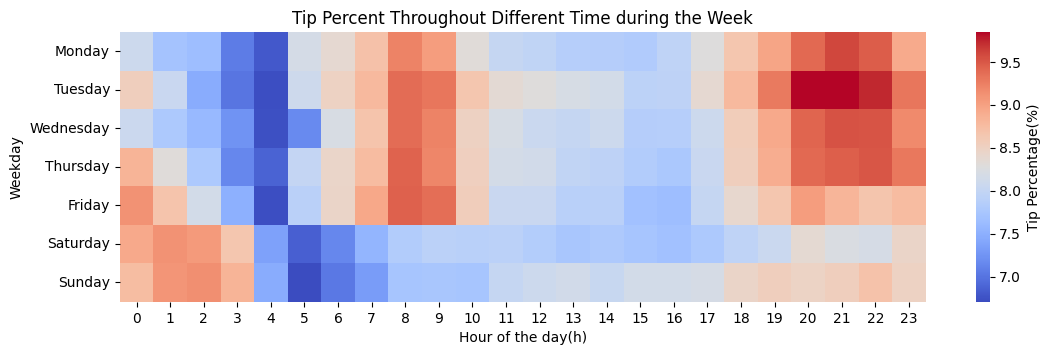

In [9]:
# compute the tipping percentage in each hour through the week
week_label=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tip_time = tip_percentage.groupby(['weekday', 'time'], as_index=False)['tip_percent'].mean()
tip_time['weekday'] = pd.Categorical(tip_time['weekday'], categories=week_label)
tip_time = tip_time.sort_values(['weekday', 'time']).reset_index(drop=True)
tip_percent_heatmap = pd.pivot_table(tip_time, values='tip_percent', index='weekday', columns='time')

fig, ax = plt.subplots(figsize=(13, 3.5))
sns.heatmap(tip_percent_heatmap, cbar_kws={'label': 'Tip Percentage(%)'}, ax=ax, cmap='coolwarm')
ax.set_ylabel('Weekday')
ax.set_xlabel('Hour of the day(h)')
ax.set_title('Tip Percent Throughout Different Time during the Week')
plt.show()

As depicted in figure above, we observed a clear difference between weekdays and weekends, suggesting that passengers tend to tip differently depending on the travelling time. Another point worth mentioning is that passengers tend to tip much more percentage of the total fare between 7:00-10:00 am and 18:00-24:00 pm on weekdays. While, during weekends, passengers prefer to tip more in the early morning between 0 to 3 am compared to the second highest during between 18:00-23:00 pm. One guess about this phenomenon is that it may relate to the demands for taxi during that time period. The two surges during weekdays occurs at the peaking time for people to work or go home when there are lots of demands (maybe larger than the supply(taxi) in the market) and people are more willing to tip when they can get the service. Besides, at the weekends, people tend to hang out or have parties during the evening until the early morning of next day and that is the high-demand period so people tip more for the valuable service.

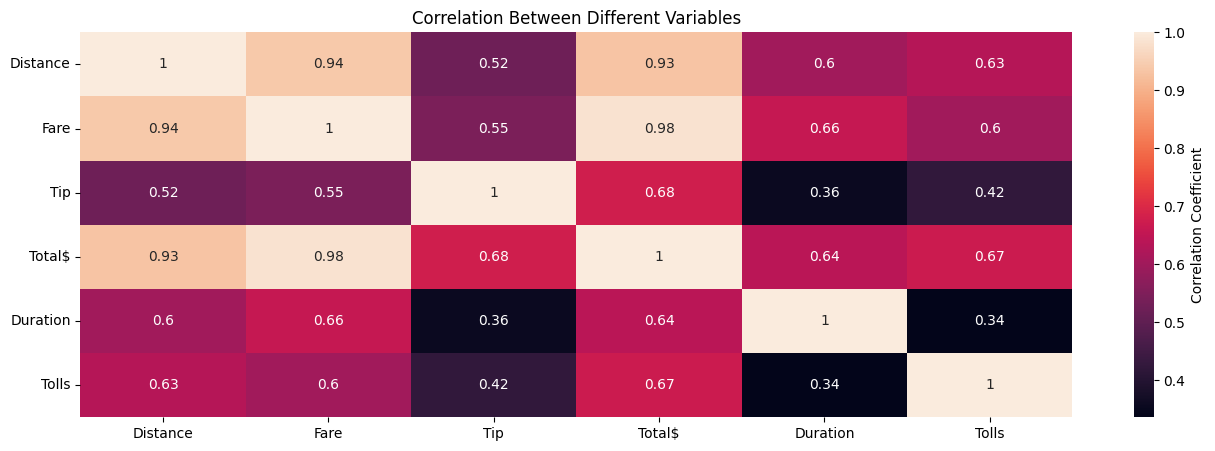

In [10]:
col = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'duration', 'tolls_amount']
label = ['Distance', 'Fare', 'Tip', 'Total$', 'Duration',  'Tolls']

# plot correlation plot
fig, ax = plt.subplots(figsize=(16, 5))
corr_matrix = tip_percentage[col].corr()
sns.heatmap(corr_matrix, annot=True, ax=ax, cbar_kws={'label': 'Correlation Coefficient'})
ax.set_xticklabels(label)
ax.set_yticklabels(label)
ax.set_title("Correlation Between Different Variables")
plt.show()

Then, we investigate the correlation between different variables. As shown in figure above, not surprisingly, the correlation coefficient between attributes like “fare amount,” “tip amount,” “total amount,” “trip distance,” and “duration” indicates there is a positive relationship between these attributes. 

# Sub-problem 4: Average speed of taxi trip

In [40]:
# read and import the data from csv file
taxi_2014 = pd.read_csv(
    './data/2014_jan.csv'
)
taxi_2014.head()
taxi_2014.columns

# convert the pickup_datetime and dropoff_datetime from type 'string' to type 'time'
taxi_2014['pickup_datetime'] = pd.to_datetime(taxi_2014['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_2014['dropoff_datetime'] = pd.to_datetime(taxi_2014['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_2014['pickup_datetime'].dtype, taxi_2014['dropoff_datetime'].dtype
# calculate the taxi travel time by measuring the time difference and denote with 'delta_t'
taxi_2014['delta_t'] =  taxi_2014['dropoff_datetime'] - taxi_2014['pickup_datetime']
# divide the trip_distance by travel time 'delt_t' and append a new column 'speed'
taxi_2014['speed'] = taxi_2014['trip_distance'] * 1000 / taxi_2014['delta_t'].dt.seconds
taxi_2014.head()

Unnamed: 0     pickup_datetime    dropoff_datetime  passenger_count  \
0           0 2014-01-09 20:45:25 2014-01-09 20:52:31                1   
1           1 2014-01-09 20:46:12 2014-01-09 20:55:12                1   
2           2 2014-01-09 20:44:47 2014-01-09 20:59:46                2   
3           3 2014-01-09 20:44:57 2014-01-09 20:51:40                1   
4           4 2014-01-09 20:47:09 2014-01-09 20:53:32                1   

   trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
0            0.7        -73.994770        40.736828         -73.982227   
1            1.4        -73.982392        40.773382         -73.960449   
2            2.3        -73.988570        40.739406         -73.986626   
3            1.7        -73.960213        40.770464         -73.979863   
4            0.9        -73.995371        40.717248         -73.984367   

   dropoff_latitude payment_type  ...  tolls_amount  total_amount  year  \
0         40.731790          CRD  ...           0.0          8.90  2014   
1         40.763995          CRD  ...           0.0         11.40  2014   
2         40.765217          CRD  ...           0.0         14.00  2014   
3         40.777050          CRD  ...           0.0         10.20  2014   
4         40.720524          CRD  ...           0.0          8.75  2014   

   month  day  hour  minute  second         delta_t     speed  
0      1    9    20      45      25 0 days 00:07:06  1.643192  
1      1    9    20      46      12 0 days 00:09:00  2.592593  
2      1    9    20      44      47 0 days 00:14:59  2.558398  
3      1    9    20      44      57 0 days 00:06:43  4.218362  
4      1    9    20      47       9 0 days 00:06:23  2.349869  

[5 rows x 24 columns]

Text(0.5, 1.0, 'Hourly average speed in weekdays')

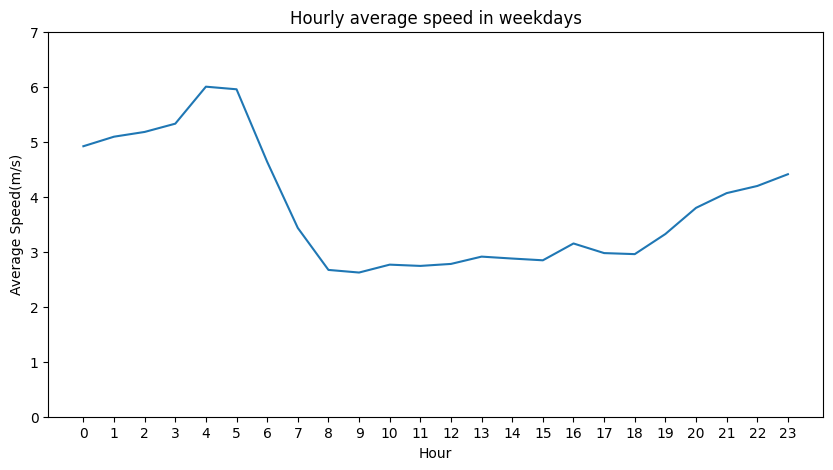

In [41]:
# pick out the travel data from 13 jan to 17 jan (from Mon to Fri) and filter out data that clearly does not meet the requirements (speed > 40 m/s)
filt = (taxi_2014['day'] >= 13) & (taxi_2014['day'] <= 17) & (taxi_2014['speed'] < 40)
taxi_weekdays = taxi_2014[filt].copy()
# use formular 'group by' to aggregate the average speed in each hour on weekdays
agg_weekdays = taxi_weekdays.groupby('hour')['speed'].agg(np.mean)
# plot the line graph and define the figure size
agg_weekdays.plot(figsize=(10,5))
# set the label interval and adjust the rotation angle of x-tick
plt.xticks(range(0,24,1), range(0,24,1), rotation=0)
plt.yticks(range(0,8,1), range(0,8,1), rotation=0)
# add labels and title
plt.xlabel('Hour')
plt.ylabel('Average Speed(m/s)')
plt.title('Hourly average speed in weekdays')


Text(0.5, 1.0, 'Hourly average speed in weekends')

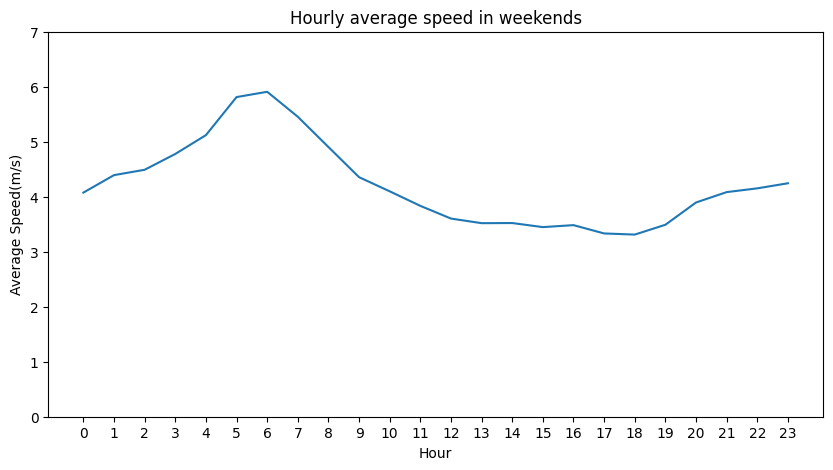

In [42]:
# pick out the travel data from 11 jan to 12 jan (Sat and Sun) and filter out data that clearly does not meet the requirements (speed > 40 m/s)
filt = (taxi_2014['day'] >= 11) & (taxi_2014['day'] <= 12) & (taxi_2014['speed'] < 40)
taxi_weekdays = taxi_2014[filt].copy()
# use formular 'group by' to aggregate the average speed in each hour on weekends
agg_weekdays = taxi_weekdays.groupby('hour')['speed'].agg(np.mean)
# plot the line graph and define the figure size
agg_weekdays.plot(figsize=(10,5))
# set the label interval and adjust the rotation angle of x-tick
plt.xticks(range(0,24,1), range(0,24,1), rotation=0)
plt.yticks(range(0,8,1), range(0,8,1), rotation=0)
# add labels and title
plt.xlabel('Hour')
plt.ylabel('Average Speed(m/s)')
plt.title('Hourly average speed in weekends')

The average speed of taxis tends to reflect the congestion on the roads within the operating area. When the average speed in an hour is greater, the roads are clearer.

The average speed of taxi movements in New York City during the day (7–17) on weekends is higher and the speed varies more slowly than on weekdays. This shows that people choose surface transport modes to travel less frequently during the day hours on weekends than on weekdays, and that traffic conditions are better.

In contrast, on weekdays, the average taxi speed from 5-8 am displayed a significant downward trend, indicating the start of the morning peak. The average road speed in New York City drops to below 3 m/s during morning rush hour, exhibiting more pronounced congestion. Due to New Yorkers' weekend nightlife, weekdays have significantly better road access during the night than weekends do. On weekday evenings, however, there is less of a need for travel, which results in less traffic on the roads.